## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 


# <span style="color:red"> Внимание! Некоторые ячейки очень долго работают (слишком долго). В начале таких ячейках я пишу об этом. Будьте внимательны к комментариям</span>

In [1]:
# Импорты

import pandas as pd
import numpy as np
from time import time
from datetime import datetime
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [3]:
df = pd.read_csv("E:\\!docum\\!HSE\\Задание машинное обучение\\ДЗ\\ДЗ4\\data.adult.csv", na_values = "?")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

In [5]:
display(df.isna().sum())

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [6]:
df.dropna(axis = 0, subset = ['workclass', 'occupation'], inplace = True)

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [7]:
#Создадим матрицу X объект-признак и целевой вектор y ("Chucn")
y = df['>50K,<=50K']
X = df.iloc[:, :-1 ]
df.drop(['>50K,<=50K'], axis=1, inplace=True)

In [8]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40


In [9]:
# Преобразуем y к бинарному формату
y = (y == '>50K').astype(int)
y

0        0
1        0
2        0
3        0
4        1
        ..
16275    0
16276    1
16277    0
16278    0
16279    1
Name: >50K,<=50K, Length: 15347, dtype: int32

In [10]:
y.value_counts(normalize=True)
# 74% ответов, что клиент не ушел
# 25% ответов, что клиент ушел
    # => выборка несбалансированная
        # => accuracy считать не стоит 

0    0.743272
1    0.256728
Name: >50K,<=50K, dtype: float64

In [11]:
# Выделим вещественные признаки
num_cols = X.columns[X.dtypes == 'int64'].tolist()
    # Отдельно выделили числовые колонки
cat_cols = X.columns[X.dtypes == 'object']
    # Отдельно выделили строковые колонки (категориальные)

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 6 numeric columns: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week
And 7 categorical columns: workclass, education, marital-status, occupation, relationship, race, sex


In [12]:
Xnum = df[['age', 'fnlwgt', 'education-num',
       'capital-gain', 'capital-loss', 'hours-per-week']]
Xnum.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


In [13]:
Xcat = df[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']]
Xcat.head()

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

$\Large \;\;\color{purple}{\text{kNN - подбор гиперпараметра n_neighbors}}$

In [14]:
# создаем словарь из параметров
params = {'n_neighbors': np.arange(1,41,1)}
# Объявили модель
grid_model_kNN01 = GridSearchCV(KNeighborsClassifier(),
                               params,
                               cv = 5,
                               scoring='roc_auc',
                               verbose=3)
# Обучили модель на ВСЕХ данных
grid_model_kNN = grid_model_kNN01.fit(Xnum, y)
print('best score roc_auc by model kNN:', grid_model_kNN.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
print('best params by model kNN:', grid_model_kNN.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.612, total=   0.1s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.611, total=   0.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.623, total=   0.1s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.615, total=   0.1s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.614, total=   0.1s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.627, total=   0.1s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.635, total=   0.1s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.639, total=   0.1s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.634, total=   0.1s
[CV] n_neighbors=2 ...................................................
[CV] .

[CV] ...................... n_neighbors=13, score=0.638, total=   0.1s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.648, total=   0.1s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.638, total=   0.1s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.638, total=   0.1s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.615, total=   0.1s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.636, total=   0.1s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.643, total=   0.1s
[CV] n_neighbors=14 ..................................................
[CV] .

[CV] ...................... n_neighbors=25, score=0.610, total=   0.1s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.619, total=   0.1s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.640, total=   0.1s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.620, total=   0.1s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.632, total=   0.1s
[CV] n_neighbors=26 ..................................................
[CV] ...................... n_neighbors=26, score=0.609, total=   0.1s
[CV] n_neighbors=26 ..................................................
[CV] ...................... n_neighbors=26, score=0.619, total=   0.1s
[CV] n_neighbors=26 ..................................................
[CV] .

[CV] ...................... n_neighbors=36, score=0.621, total=   0.2s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.611, total=   0.1s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.614, total=   0.2s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.645, total=   0.1s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.616, total=   0.1s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.618, total=   0.1s
[CV] n_neighbors=38 ..................................................
[CV] ...................... n_neighbors=38, score=0.611, total=   0.1s
[CV] n_neighbors=38 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.7s finished


In [15]:
'''
# график среднего качества

# Положим в датафрейм некоторые характеристики 
df_kNN_cv_res = pd.DataFrame(grid_model_kNN.cv_results_)
y_kNN = df_kNN_cv_res['mean_test_score']
x_kNN = np.arange(1, 26)

# Построение графика
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
    # [0,0,1,1]:
        # число 3 = длина
        # число 4 = ширина
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
ax.grid()    # наложили для удобства сетку
ax.plot(x_kNN, y_kNN, lw=3)
    # lw - ширина линии
plt.xlim([1,25])
    
# 95% доверительный интервал
y_coordinate_up = df_kNN_cv_res['mean_test_score'] + 1.96 * (df_kNN_cv_res['std_test_score']/5**(1/2))
y_coordinate_low = df_kNN_cv_res['mean_test_score'] - 1.96 * (df_kNN_cv_res['std_test_score']/5**(1/2))
ax.fill_between(x_kNN, y_coordinate_low, y_coordinate_up, alpha = 0.3)

    
ax.set_ylabel('mean_test_score')
ax.set_xlabel('n_neighbors')
ax.set_title('Динамика среднего качества в зависимости от кол-ва соседей')
plt.show()
'''

"\n# график среднего качества\n\n# Положим в датафрейм некоторые характеристики \ndf_kNN_cv_res = pd.DataFrame(grid_model_kNN.cv_results_)\ny_kNN = df_kNN_cv_res['mean_test_score']\nx_kNN = np.arange(1, 26)\n\n# Построение графика\nfig = plt.figure()\nax = fig.add_axes([0,0,2,1])\n    # [0,0,1,1]:\n        # число 3 = длина\n        # число 4 = ширина\nax.xaxis.set_major_locator(ticker.MultipleLocator(1))\nax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))\nax.grid()    # наложили для удобства сетку\nax.plot(x_kNN, y_kNN, lw=3)\n    # lw - ширина линии\nplt.xlim([1,25])\n    \n# 95% доверительный интервал\ny_coordinate_up = df_kNN_cv_res['mean_test_score'] + 1.96 * (df_kNN_cv_res['std_test_score']/5**(1/2))\ny_coordinate_low = df_kNN_cv_res['mean_test_score'] - 1.96 * (df_kNN_cv_res['std_test_score']/5**(1/2))\nax.fill_between(x_kNN, y_coordinate_low, y_coordinate_up, alpha = 0.3)\n\n    \nax.set_ylabel('mean_test_score')\nax.set_xlabel('n_neighbors')\nax.set_title('Динамика сре

In [16]:
def draw_graphics(model, x , x_min, x_max, ylabel, xlabel, title):

    # Положим в датафрейм некоторые характеристики 
    df_res = pd.DataFrame(model.cv_results_)
    y = df_res['mean_test_score']

    # Построение графика
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
        # [0,0,1,1]:
            # число 3 = длина
            # число 4 = ширина
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
    ax.grid()    # наложили для удобства сетку
    ax.plot(x, y, lw=3)
        # lw - ширина линии
    plt.xlim([x_min, x_max])

    # 95% доверительный интервал
    y_coordinate_up = df_res['mean_test_score'] + 1.96 * (df_res['std_test_score']/5**(1/2))
    y_coordinate_low = df_res['mean_test_score'] - 1.96 * (df_res['std_test_score']/5**(1/2))
    ax.fill_between(x, y_coordinate_low, y_coordinate_up, alpha = 0.3)


    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

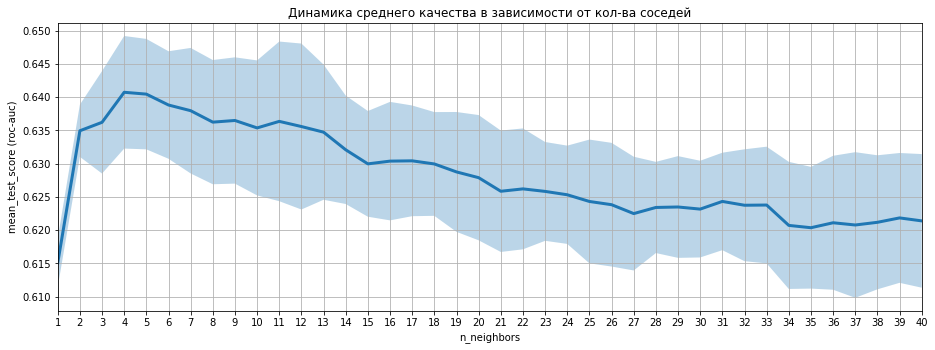

In [24]:
x_kNN = np.arange(1,41,1)

draw_graphics(grid_model_kNN, x_kNN, 1, 40,
              'mean_test_score (roc-auc)', 'n_neighbors', 'Динамика среднего качества в зависимости от кол-ва соседей')

$\Large \;\;\color{purple}{\text{DecisonTree — подбор гиперпараметра max_depth}}$

In [26]:
# создаем словарь из параметров
params = {'max_depth': np.arange(1,41,1)}
# Объявили модель
grid_model_tree01 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               params,
                               cv = 5,
                               scoring='roc_auc',
                               verbose=3)
# Обучили модель на ВСЕХ данных
grid_model_tree = grid_model_tree01.fit(Xnum, y)
print('best score roc_auc by model decision tree:', grid_model_tree.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
print('best params by model decision tree:', grid_model_tree.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра 'max_depth'

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.588, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.591, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.591, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.593, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.599, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.719, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.716, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.711, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.726, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... max_depth=3, score=0.787, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.786, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.800, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.794, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ......................... max_depth=4, score=0.810, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ......................... max_depth=4, score=0.809, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ......................... max_depth=4, score=0.812, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] .

[CV] ........................ max_depth=15, score=0.769, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.765, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.764, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.786, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ........................ max_depth=16, score=0.772, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ........................ max_depth=16, score=0.753, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ........................ max_depth=16, score=0.759, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] .

[CV] ........................ max_depth=27, score=0.690, total=   0.1s
[CV] max_depth=27 ....................................................
[CV] ........................ max_depth=27, score=0.695, total=   0.1s
[CV] max_depth=27 ....................................................
[CV] ........................ max_depth=27, score=0.703, total=   0.1s
[CV] max_depth=28 ....................................................
[CV] ........................ max_depth=28, score=0.697, total=   0.1s
[CV] max_depth=28 ....................................................
[CV] ........................ max_depth=28, score=0.691, total=   0.0s
[CV] max_depth=28 ....................................................
[CV] ........................ max_depth=28, score=0.691, total=   0.1s
[CV] max_depth=28 ....................................................
[CV] ........................ max_depth=28, score=0.690, total=   0.1s
[CV] max_depth=28 ....................................................
[CV] .

[CV] ........................ max_depth=39, score=0.682, total=   0.1s
[CV] max_depth=39 ....................................................
[CV] ........................ max_depth=39, score=0.684, total=   0.1s
[CV] max_depth=39 ....................................................
[CV] ........................ max_depth=39, score=0.681, total=   0.1s
[CV] max_depth=39 ....................................................
[CV] ........................ max_depth=39, score=0.698, total=   0.1s
[CV] max_depth=40 ....................................................
[CV] ........................ max_depth=40, score=0.686, total=   0.1s
[CV] max_depth=40 ....................................................
[CV] ........................ max_depth=40, score=0.680, total=   0.1s
[CV] max_depth=40 ....................................................
[CV] ........................ max_depth=40, score=0.682, total=   0.1s
[CV] max_depth=40 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.0s finished


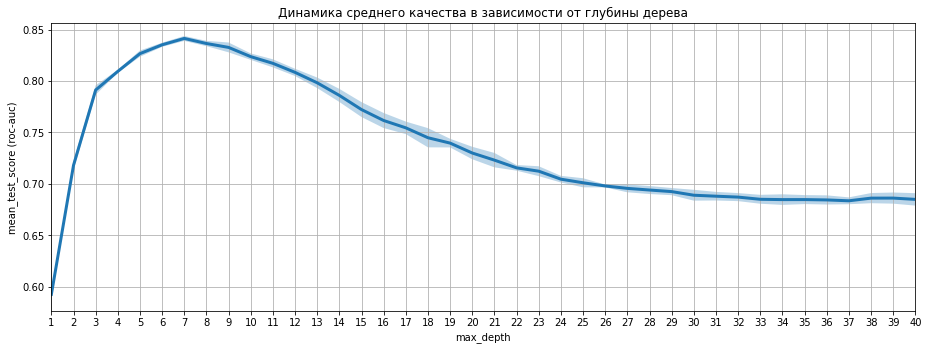

In [27]:
x_tree = np.arange(1,41,1)

draw_graphics(grid_model_tree, x_tree, 1, 40,
              'mean_test_score (roc-auc)', 'max_depth', 'Динамика среднего качества в зависимости от глубины дерева')

$\Large \;\;\color{purple}{\text{SGD Linear Classifier — подбор гиперпараметра loss}}$

In [28]:
params = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge',
         'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}

# Объявили модель
grid_model_sgd01 = GridSearchCV(SGDClassifier(random_state=42),
                               params,
                               cv = 5,
                               scoring='roc_auc',
                               verbose=3)
# Обучили модель на ВСЕХ данных
grid_model_sgd = grid_model_sgd01.fit(Xnum, y)
print('best score roc_auc by model SGDClassifier:', grid_model_sgd.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
print('best params by model SGDClassifier:', grid_model_sgd.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра 'max_depth'

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.570, total=   0.2s
[CV] loss=hinge ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... loss=hinge, score=0.580, total=   0.2s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.621, total=   0.1s
[CV] loss=hinge ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .......................... loss=hinge, score=0.623, total=   0.2s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.622, total=   0.2s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.568, total=   0.4s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.582, total=   0.3s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.637, total=   0.3s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.626, total=   0.4s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.623, total=   0.3s
[CV] loss=modified_huber .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   19.5s finished


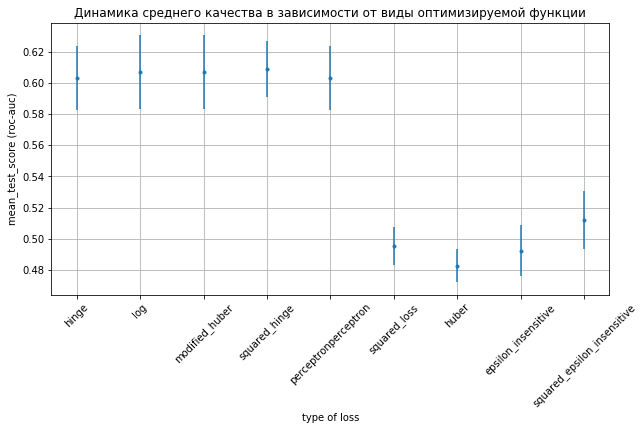

In [29]:
# Положим в датафрейм некоторые характеристики 
df_sgd_cv_res = pd.DataFrame(grid_model_sgd.cv_results_)
y_sgd = df_sgd_cv_res['mean_test_score']
x_sgd = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron''perceptron',
         'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']

# Построение графика
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()  
ax.errorbar(x_sgd, y_sgd, yerr = (1.96 * (df_sgd_cv_res['std_test_score']/5**(1/2))), linestyle ='', marker='.')
        
ax.set_ylabel('mean_test_score (roc-auc)')
ax.set_xlabel('type of loss')
ax.set_title('Динамика среднего качества в зависимости от виды оптимизируемой функции')
plt.xticks(rotation = 45)
plt.show()


Что вы можете сказать о получившихся графиках?

**Ответ**: Из вышеприведенных графиков видно, что по критерию ROC-AUC среди рассматриваемых семейств моделей наилучшей моделью является решающее дерево с параметром `max_depth=7`. БОльшие значения этого параметра ведут к ухудшению усредненной метрики качества на кросс-валидации, то есть к переобучению. Аналлогично для KNN классификатора: число соседей, которое больше четрыех, заставляет модель переобучаться.

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [30]:
# ЛУЧШЕ НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ, ДОЛГО ВЫПОЛНЯЕТСЯ (11 мин примерно) 
params = {'n_estimators': np.arange(10,401,10)}
grid_model_forest01 = GridSearchCV(RandomForestClassifier(random_state=42),
                               params,
                               cv = 5,
                               scoring='roc_auc',
                               verbose=3)

# Обучили модель на ВСЕХ данных
grid_model_forest = grid_model_forest01.fit(Xnum, y)
print('best score roc_auc by model random forest:', grid_model_forest.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
print('best params by model random forest:',grid_model_forest.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра 'max_depth'

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, score=0.795, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.791, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.792, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.788, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.789, total=   0.2s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.810, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.804, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.806, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.796, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] .

[CV] .................... n_estimators=130, score=0.819, total=   2.0s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.819, total=   2.1s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.816, total=   2.1s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.811, total=   2.1s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.824, total=   2.2s
[CV] n_estimators=140 ................................................
[CV] .................... n_estimators=140, score=0.819, total=   2.1s
[CV] n_estimators=140 ................................................
[CV] .................... n_estimators=140, score=0.819, total=   2.2s
[CV] n_estimators=140 ................................................
[CV] .

[CV] .................... n_estimators=240, score=0.812, total=   3.7s
[CV] n_estimators=240 ................................................
[CV] .................... n_estimators=240, score=0.826, total=   3.7s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.821, total=   3.8s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.820, total=   3.8s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.818, total=   3.8s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.812, total=   3.8s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.826, total=   3.8s
[CV] n_estimators=260 ................................................
[CV] .

[CV] .................... n_estimators=360, score=0.821, total=   5.4s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.819, total=   5.5s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.812, total=   5.7s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.827, total=   5.6s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.821, total=   5.6s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.821, total=   5.5s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.819, total=   6.1s
[CV] n_estimators=370 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.0min finished


best score roc_auc by model random forest: 0.8199680297587243
best params by model random forest: {'n_estimators': 400}


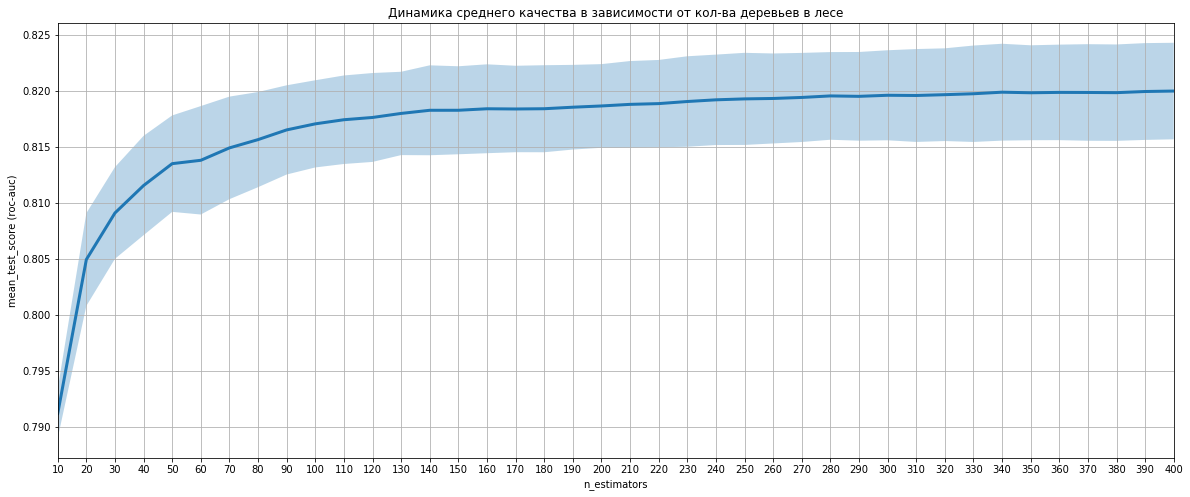

In [32]:
# график среднего качества

# Положим в датафрейм некоторые характеристики 
df_RF_cv_res = pd.DataFrame(grid_model_forest.cv_results_)
y_RF = df_RF_cv_res['mean_test_score']
x_RF = np.arange(10,401,10)

# Построение графика
fig, ax = plt.subplots(figsize=(20, 8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
ax.grid()    # наложили для удобства сетку
ax.plot(x_RF, y_RF, lw=3)
    # lw - ширина линии
plt.xlim([10,400])
    
# 95% доверительный интервал
y_coordinate_up = df_RF_cv_res['mean_test_score'] + 1.96 * (df_RF_cv_res['std_test_score']/5**(1/2))
y_coordinate_low = df_RF_cv_res['mean_test_score'] - 1.96 * (df_RF_cv_res['std_test_score']/5**(1/2))
ax.fill_between(x_RF, y_coordinate_low, y_coordinate_up, alpha = 0.3)

    
ax.set_ylabel('mean_test_score (roc-auc)')
ax.set_xlabel('n_estimators')
ax.set_title('Динамика среднего качества в зависимости от кол-ва деревьев в лесе')
plt.show()

**Ответ**: Примерно на значении параметра `n_estimators=140` кроссвалидационная метрика стабилизируется. Дальнейшее увеличение числа деревьев незначительно уаеличивает качество модели.

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [33]:
# ЭТУ ЯЧЕЙКУ ТОЖЕ ЛУЧШЕ НЕ ЗАПУСКАТЬ, ВЫПОЛНЯЕТСЯ ДОЛГО (6 мин примерно) 
gr_boost_train_mse,  gr_boost_test_mse = [], []
n_trees = np.arange(10, 1500, 10)
X_train, X_test, y_train, y_test = train_test_split(Xnum, y, test_size=0.8, random_state=42)


for i in tqdm(n_trees):
        # объявляем модель
    gr_boost01 = GradientBoostingClassifier(n_estimators=i, random_state=42)
        # обучаем на train
    gr_boost = gr_boost01.fit(X_train, y_train)

    # Делаем предсказание на train и считаем MSE ошибку на train
    #gr_boost_train_mse.append(mean_squared_error(y_train,  gr_boost.predict(X_train)))
        # Делаем предсказание на test и считаем MSE ошибку на test
    #gr_boost_test_mse.append(mean_squared_error(y_test, gr_boost.predict(X_test)))
    
        # Делаем предсказание на train и считаем log-loss ошибку на train
    gr_boost_train_mse.append(log_loss(y_train,  gr_boost.predict_proba(X_train)[:, 1]))
        # Делаем предсказание на test и считаем log-loss ошибку на test
    gr_boost_test_mse.append(log_loss(y_test, gr_boost.predict_proba(X_test)[:, 1]))



100%|████████████████████████████████████████| 149/149 [06:41<00:00,  2.69s/it]


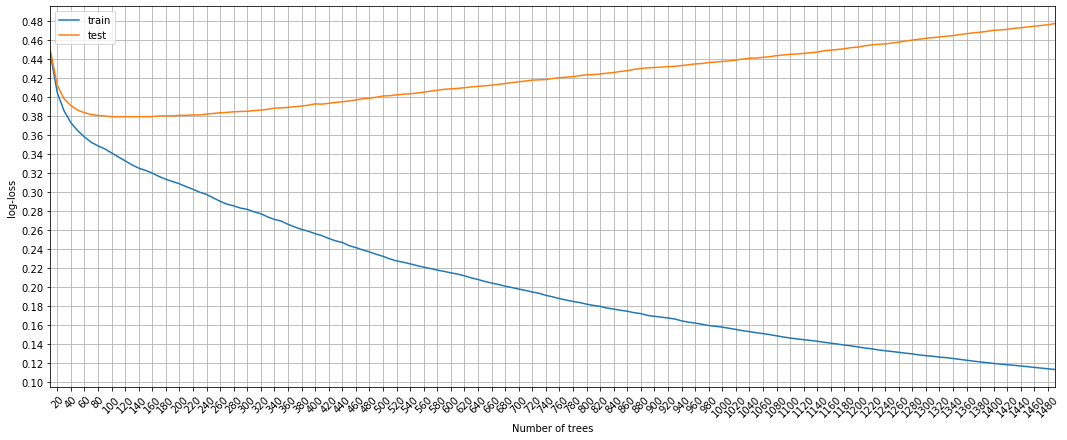

In [42]:
# Нарисуем 2 графика: ошибку на train и ошибку на test в зависимости от кол-ва деревьев
fig, ax = plt.subplots(figsize=(18,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.plot(n_trees, gr_boost_train_mse, label='train')
plt.plot(n_trees, gr_boost_test_mse, label='test')
plt.xlim([10,1490])
ax.grid()
plt.ylabel('log-loss')
plt.xlabel('Number of trees')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

**Ответ**: Примерно при значении параметра `n_estimators=100` ошибка бустинга на тестовых данных достигает своего минимума, после чего начинает расти.

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

$\Large \;\;\color{violet}{\text{Построение гистограмм}}$

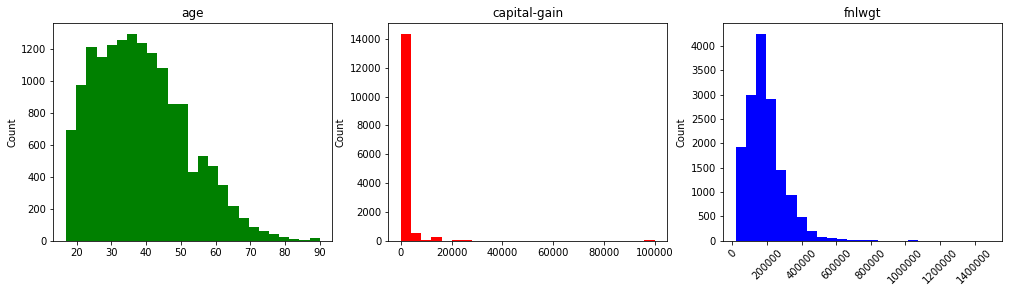

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(17,4))
ax[0].hist(df['age'], bins = 25, color ='g')
ax[0].set_title('age')
ax[0].set_ylabel('Count')

ax[2].hist(df['fnlwgt'], bins = 25, color ='b')
ax[2].set_title('fnlwgt')
ax[2].set_ylabel('Count')

ax[1].hist(df['capital-gain'], bins = 25, color ='r')
ax[1].set_title('capital-gain')
ax[1].set_ylabel('Count')
plt.xticks(rotation = 45)

plt.show()

**Ответ:** Из графиков видно, что признаки age, fnlwgt и capital-gain имеют разный диапазон значений, разное распределение. Возраст не превышает 100, а fnlwgt может быть больше 100 000. Эти факторы могут привести к тому, что одни признаки будут сильнее влиять, чем другие (kNN (вклад в расстояние у признаков разный), SGD Linear Classifier). Решающие деревья нечувствительны к разным масштабам признаков. Соответственно для Random Forest и Gradient Boosting тоже не важно отмасштабированы признаки или нет. Получается масштабирование сможет улучшить работу kNN и SGD Linear Classifier.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

$\Large \;\;\color{violet}{\text{масштабирование столбцов}}$

In [52]:
# масштабирование будем производить с помощью StandardScaler
scaler01 = StandardScaler()
Xnum_new = scaler01.fit_transform(Xnum)

In [53]:
Xnum_new.shape

(15347, 6)

In [54]:
# Но у StandardScaler есть один недостаток - он возвращает numpy arrays, а не pandas dataframe.
# переведем обратно отмасштабированные признаки в pandas dataframe
name_col = Xnum.columns
Xnum2 = pd.DataFrame(Xnum_new, columns = name_col)

In [55]:
Xnum2

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


$\Large \;\;\color{violet}{\text{подбор оптимальных значений гиперпараметров}}$

In [56]:
# Напишем функцию для подбора оптимальных гиперпарметров
def opt_params(model, params):
    # Объявили модель
    grid_model01 = GridSearchCV(model,
                        params,
                        cv = 5,
                        scoring='roc_auc',
                        verbose=3)
    # Обучили модель на ВСЕХ данных
    grid_model = grid_model01.fit(Xnum2, y)
    print('best score roc_auc', grid_model.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
    print('best params', grid_model.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра
    
    return grid_model

$\Large \;\;\color{purple}{\text{kNN - подбор гиперпараметра n_neighbors}}$

In [60]:
# создаем словарь из параметров
params = {'n_neighbors': np.arange(1,101,1)}
grid_model_kNN_sc = opt_params(KNeighborsClassifier(), params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.669, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.671, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.668, total=   0.3s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.648, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.674, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.726, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.728, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.728, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.709, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] .

[CV] ...................... n_neighbors=13, score=0.825, total=   0.3s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.824, total=   0.3s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.817, total=   0.3s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.809, total=   0.3s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.822, total=   0.3s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.826, total=   0.3s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.828, total=   0.3s
[CV] n_neighbors=14 ..................................................
[CV] .

[CV] ...................... n_neighbors=24, score=0.825, total=   0.4s
[CV] n_neighbors=24 ..................................................
[CV] ...................... n_neighbors=24, score=0.833, total=   0.4s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.832, total=   0.4s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.838, total=   0.3s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.827, total=   0.4s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.826, total=   0.4s
[CV] n_neighbors=25 ..................................................
[CV] ...................... n_neighbors=25, score=0.832, total=   0.4s
[CV] n_neighbors=26 ..................................................
[CV] .

[CV] ...................... n_neighbors=36, score=0.841, total=   0.4s
[CV] n_neighbors=36 ..................................................
[CV] ...................... n_neighbors=36, score=0.831, total=   0.4s
[CV] n_neighbors=36 ..................................................
[CV] ...................... n_neighbors=36, score=0.828, total=   0.6s
[CV] n_neighbors=36 ..................................................
[CV] ...................... n_neighbors=36, score=0.834, total=   0.7s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.835, total=   0.5s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.840, total=   0.5s
[CV] n_neighbors=37 ..................................................
[CV] ...................... n_neighbors=37, score=0.832, total=   0.5s
[CV] n_neighbors=37 ..................................................
[CV] .

[CV] ...................... n_neighbors=47, score=0.832, total=   0.4s
[CV] n_neighbors=48 ..................................................
[CV] ...................... n_neighbors=48, score=0.837, total=   0.5s
[CV] n_neighbors=48 ..................................................
[CV] ...................... n_neighbors=48, score=0.841, total=   0.4s
[CV] n_neighbors=48 ..................................................
[CV] ...................... n_neighbors=48, score=0.831, total=   0.4s
[CV] n_neighbors=48 ..................................................
[CV] ...................... n_neighbors=48, score=0.827, total=   0.4s
[CV] n_neighbors=48 ..................................................
[CV] ...................... n_neighbors=48, score=0.831, total=   0.5s
[CV] n_neighbors=49 ..................................................
[CV] ...................... n_neighbors=49, score=0.838, total=   0.6s
[CV] n_neighbors=49 ..................................................
[CV] .

[CV] ...................... n_neighbors=59, score=0.831, total=   0.5s
[CV] n_neighbors=59 ..................................................
[CV] ...................... n_neighbors=59, score=0.827, total=   0.4s
[CV] n_neighbors=59 ..................................................
[CV] ...................... n_neighbors=59, score=0.832, total=   0.5s
[CV] n_neighbors=60 ..................................................
[CV] ...................... n_neighbors=60, score=0.839, total=   0.4s
[CV] n_neighbors=60 ..................................................
[CV] ...................... n_neighbors=60, score=0.840, total=   0.5s
[CV] n_neighbors=60 ..................................................
[CV] ...................... n_neighbors=60, score=0.831, total=   0.6s
[CV] n_neighbors=60 ..................................................
[CV] ...................... n_neighbors=60, score=0.827, total=   0.5s
[CV] n_neighbors=60 ..................................................
[CV] .

[CV] ...................... n_neighbors=71, score=0.838, total=   0.8s
[CV] n_neighbors=71 ..................................................
[CV] ...................... n_neighbors=71, score=0.839, total=   0.7s
[CV] n_neighbors=71 ..................................................
[CV] ...................... n_neighbors=71, score=0.830, total=   0.6s
[CV] n_neighbors=71 ..................................................
[CV] ...................... n_neighbors=71, score=0.825, total=   0.5s
[CV] n_neighbors=71 ..................................................
[CV] ...................... n_neighbors=71, score=0.833, total=   0.5s
[CV] n_neighbors=72 ..................................................
[CV] ...................... n_neighbors=72, score=0.838, total=   0.5s
[CV] n_neighbors=72 ..................................................
[CV] ...................... n_neighbors=72, score=0.840, total=   0.5s
[CV] n_neighbors=72 ..................................................
[CV] .

[CV] ...................... n_neighbors=82, score=0.825, total=   0.6s
[CV] n_neighbors=82 ..................................................
[CV] ...................... n_neighbors=82, score=0.834, total=   0.7s
[CV] n_neighbors=83 ..................................................
[CV] ...................... n_neighbors=83, score=0.838, total=   0.7s
[CV] n_neighbors=83 ..................................................
[CV] ...................... n_neighbors=83, score=0.839, total=   0.7s
[CV] n_neighbors=83 ..................................................
[CV] ...................... n_neighbors=83, score=0.831, total=   0.7s
[CV] n_neighbors=83 ..................................................
[CV] ...................... n_neighbors=83, score=0.826, total=   0.6s
[CV] n_neighbors=83 ..................................................
[CV] ...................... n_neighbors=83, score=0.833, total=   0.6s
[CV] n_neighbors=84 ..................................................
[CV] .

[CV] ...................... n_neighbors=94, score=0.838, total=   0.5s
[CV] n_neighbors=94 ..................................................
[CV] ...................... n_neighbors=94, score=0.830, total=   0.5s
[CV] n_neighbors=94 ..................................................
[CV] ...................... n_neighbors=94, score=0.826, total=   0.5s
[CV] n_neighbors=94 ..................................................
[CV] ...................... n_neighbors=94, score=0.833, total=   0.5s
[CV] n_neighbors=95 ..................................................
[CV] ...................... n_neighbors=95, score=0.838, total=   0.6s
[CV] n_neighbors=95 ..................................................
[CV] ...................... n_neighbors=95, score=0.838, total=   0.7s
[CV] n_neighbors=95 ..................................................
[CV] ...................... n_neighbors=95, score=0.830, total=   0.7s
[CV] n_neighbors=95 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.9min finished


best score roc_auc 0.8342380287757438
best params {'n_neighbors': 39}


$\Large \;\;\color{purple}{\text{DecisonTree — подбор гиперпараметра max_depth}}$

In [61]:
# создаем словарь из параметров
params = {'max_depth': np.arange(1,20,1)}
grid_model_tree_sc = opt_params(DecisionTreeClassifier(random_state=42), params)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.588, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.591, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.591, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.593, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.599, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.719, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... max_depth=3, score=0.790, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.787, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.786, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.800, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.794, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ......................... max_depth=4, score=0.810, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ......................... max_depth=4, score=0.809, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] .

[CV] ........................ max_depth=14, score=0.777, total=   0.0s
[CV] max_depth=14 ....................................................
[CV] ........................ max_depth=14, score=0.798, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.778, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.769, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.766, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.765, total=   0.0s
[CV] max_depth=15 ....................................................
[CV] ........................ max_depth=15, score=0.787, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    3.8s finished


$\Large \;\;\color{purple}{\text{SGD Linear Classifier — подбор гиперпараметра loss}}$

In [62]:
# создаем словарь из параметров
params = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
                   'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
grid_model_sgd_sc = opt_params(SGDClassifier(), params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] loss=hinge ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... loss=hinge, score=0.793, total=   0.0s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.799, total=   0.1s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.817, total=   0.1s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.811, total=   0.1s
[CV] loss=hinge ......................................................
[CV] .......................... loss=hinge, score=0.816, total=   0.1s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.827, total=   0.1s
[CV] loss=log ........................................................
[CV] ............................ loss=log, score=0.825, total=   0.0s
[CV] loss=log ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.3s finished


$\Large \;\;\color{purple}{\text{RandomForest — подбор гиперпараметра n_estimators}}$

In [296]:
# ЛУЧШЕ НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ, ДОЛГО ВЫПОЛНЯЕТСЯ (11 мин примерно) 
params = {'n_estimators': np.arange(10,401,10)}
grid_model_forest_sc = opt_params(RandomForestClassifier(random_state=42), params)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.797, total=   0.2s
[CV] n_estimators=10 .................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] ..................... n_estimators=10, score=0.790, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.791, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.788, total=   0.1s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.790, total=   0.2s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.811, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.804, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.806, total=   0.4s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.796, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] .

[CV] .................... n_estimators=130, score=0.819, total=   1.9s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.818, total=   2.3s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.816, total=   2.5s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.811, total=   2.5s
[CV] n_estimators=130 ................................................
[CV] .................... n_estimators=130, score=0.825, total=   2.2s
[CV] n_estimators=140 ................................................
[CV] .................... n_estimators=140, score=0.820, total=   2.2s
[CV] n_estimators=140 ................................................
[CV] .................... n_estimators=140, score=0.819, total=   2.1s
[CV] n_estimators=140 ................................................
[CV] .

[CV] .................... n_estimators=240, score=0.812, total=   4.4s
[CV] n_estimators=240 ................................................
[CV] .................... n_estimators=240, score=0.827, total=   4.4s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.821, total=   4.4s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.820, total=   4.6s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.818, total=   4.6s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.812, total=   4.6s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.827, total=   3.8s
[CV] n_estimators=260 ................................................
[CV] .

[CV] .................... n_estimators=360, score=0.821, total=   5.3s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.819, total=   6.2s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.812, total=   5.8s
[CV] n_estimators=360 ................................................
[CV] .................... n_estimators=360, score=0.828, total=   5.5s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.821, total=   5.7s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.821, total=   6.0s
[CV] n_estimators=370 ................................................
[CV] .................... n_estimators=370, score=0.819, total=   5.5s
[CV] n_estimators=370 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.8min finished


best score roc_auc 0.8199736072092433
best params {'n_estimators': 400}


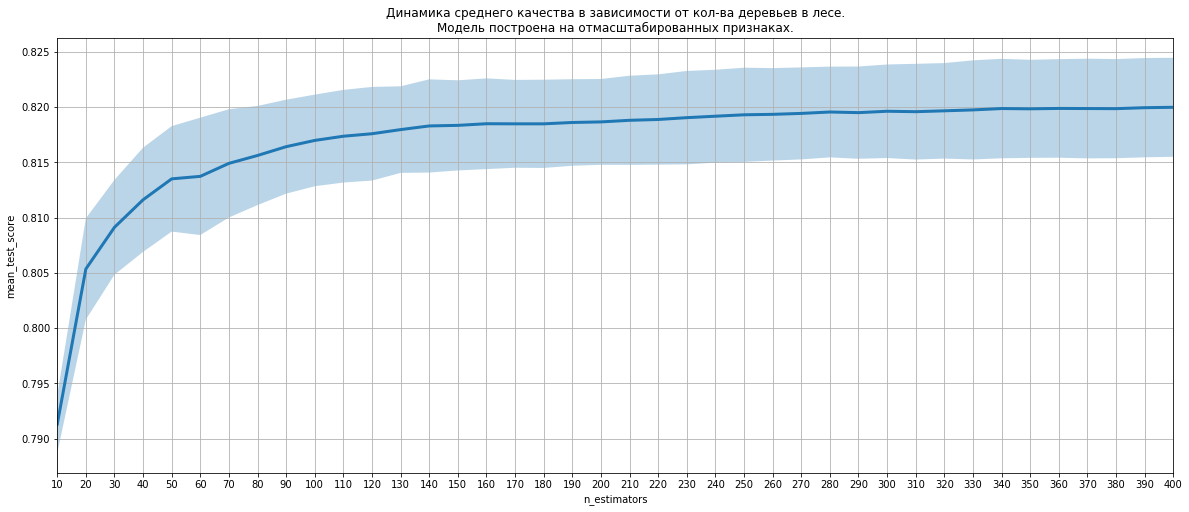

In [297]:
# график среднего качества

# Положим в датафрейм некоторые характеристики 
df_RFsc_cv_res = pd.DataFrame(grid_model_forest_sc.cv_results_)
y_RFsc = df_RFsc_cv_res['mean_test_score']
x_RF = np.arange(10,401,10)

# Построение графика
fig, ax = plt.subplots(figsize=(20, 8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
ax.grid()    # наложили для удобства сетку
ax.plot(x_RF, y_RFsc, lw=3)
    # lw - ширина линии
plt.xlim([10,400])
    
# 95% доверительный интервал
y_coordinate_up = df_RFsc_cv_res['mean_test_score'] + 1.96 * (df_RFsc_cv_res['std_test_score']/5**(1/2))
y_coordinate_low = df_RFsc_cv_res['mean_test_score'] - 1.96 * (df_RFsc_cv_res['std_test_score']/5**(1/2))
ax.fill_between(x_RF, y_coordinate_low, y_coordinate_up, alpha = 0.3)

    
ax.set_ylabel('mean_test_score')
ax.set_xlabel('n_estimators')
ax.set_title('Динамика среднего качества в зависимости от кол-ва деревьев в лесе.\nМодель построена на отмасштабированных признаках.')
plt.show()

In [271]:
RF_cross_val_0 = cross_val_score(RandomForestClassifier(n_estimators = 140,
                                                     random_state=42),
                                X=Xnum2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Random Forest:', RF_cross_val_0.mean())

best mean score roc_auc by model Random Forest: 0.8182861315037442


$\Large \;\;\color{purple}{\text{GradientBoosting — подбор гиперпараметра n_estimators}}$

In [298]:
gr_boost_sc_train_mse,  gr_boost_sc_test_mse = [], []
n_trees = np.arange(10, 1500, 10)
X_train, X_test, y_train, y_test = train_test_split(Xnum2, y, test_size=0.8, random_state=42)


for i in tqdm(n_trees):
        # объявляем модель
    gr_boost01 = GradientBoostingClassifier(n_estimators=i, random_state=42)
        # обучаем на train
    gr_boost = gr_boost01.fit(X_train, y_train)

    # Делаем предсказание на train и считаем MSE ошибку на train
    #gr_boost_sc_train_mse.append(mean_squared_error(y_train,  gr_boost.predict(X_train)))
        # Делаем предсказание на test и считаем MSE ошибку на test
    #gr_boost_sc_test_mse.append(mean_squared_error(y_test, gr_boost.predict(X_test)))
    
        # Делаем предсказание на train и считаем MSE ошибку на train
    gr_boost_sc_train_mse.append(log_loss(y_train,  gr_boost.predict_proba(X_train)[:, 1]))
        # Делаем предсказание на test и считаем MSE ошибку на test
    gr_boost_sc_test_mse.append(log_loss(y_test, gr_boost.predict_proba(X_test)[:, 1]))



100%|████████████████████████████████████████| 149/149 [06:57<00:00,  2.80s/it]


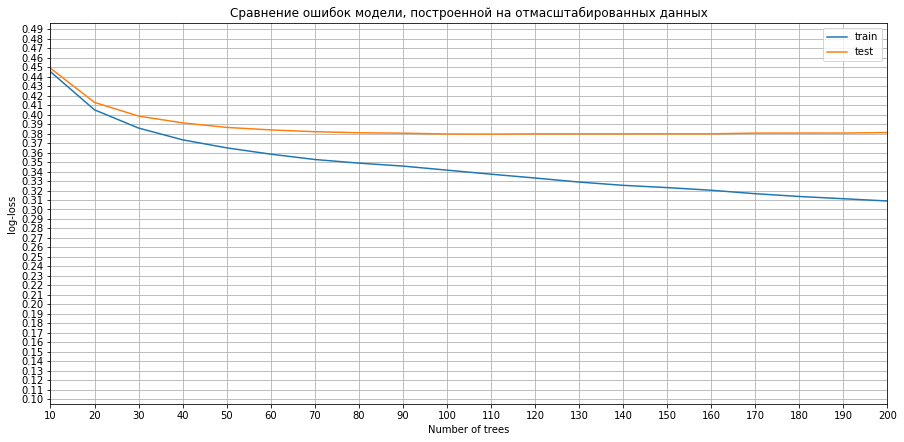

In [299]:
# Нарисуем 2 графика: ошибку на train и ошибку на test в зависимости от кол-ва деревьев
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.plot(n_trees, gr_boost_sc_train_mse, label='train')
plt.plot(n_trees, gr_boost_sc_test_mse, label='test')
plt.xlim([10,200])
ax.grid()
plt.ylabel('log-loss')
plt.xlabel('Number of trees')
plt.legend()
ax.set_title('Сравнение ошибок модели, построенной на отмасштабированных данных')
plt.show()

In [270]:
GB_cross_val_0 = cross_val_score(GradientBoostingClassifier(n_estimators=100, random_state=42),
                             X=Xnum2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Gradient Boosting:', GB_cross_val_0.mean())

best mean score roc_auc by model Gradient Boosting: 0.8621174962677267


In [272]:
name_col_model = ['KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SGD Linear Classifier']
data_metrics_sc = [grid_model_kNN_sc.best_score_, grid_model_tree_sc.best_score_, RF_cross_val_0.mean(), GB_cross_val_0.mean(), grid_model_sgd_sc.best_score_,]
data_metrics = [grid_model_kNN.best_score_, grid_model_tree.best_score_, RF_cross_val_0.mean(), GB_cross_val_0.mean(), grid_model_sgd.best_score_]

metrics = pd.DataFrame(columns = name_col_model)
metrics.loc[len(metrics)] = data_metrics
metrics.loc[len(metrics)] = data_metrics_sc
metrics.index = ['Неотмасштабированные признаки', 'Отмасштабированные признаки']


In [273]:
metrics

,KNN,Decision Tree,Random Forest,Gradient Boosting,SGD Linear Classifier
Неотмасштабированные признаки,0.640717,0.841435,0.818286,0.862117,0.609055
Отмасштабированные признаки,0.834238,0.841404,0.818286,0.862117,0.821853


Изменилось ли качество у некоторых алгоритмов?

**Ответ:** как и следовало ожидать, качество алгоритмов KNN и SGD Linear Classifier заметно улучшилось. Качество решающего дерева, случайного дерева и градиентного бустинга не изменилось (поскольку они не чувствительно к скалированию).

Также:
- У метода ближ соседей значительно изменилось качество и изменился оптимальный гипер параметр.
Изначально было `n_neighbors=4`, а стало `n_neighbors=39`. Это связано с тем, что без масштабирования вклад признака зависит от размерности (расстояние до соседа)
- У SGD Linear Classifier изменилась оптимальная оптимизируемая функция. Была `loss = 'squared_hinge'`, а стала `loss = 'log'`

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

$\color{purple}{\text{KNN — число соседей (n_neighbors) и метрика (metric)}}$

In [95]:
# будем использовать метрики, которые не требуют дополнительных настроек (доп параметров)
params = {'n_neighbors': np.arange(30,100,5), 'metric': ['euclidean', 'manhattan', 'chebyshev']}

a = datetime.now()
grid_model_kNN_sc_v2 = opt_params(KNeighborsClassifier(), params)
b = datetime.now()
delta_time_kNN = b - a

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] metric=euclidean, n_neighbors=30 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... metric=euclidean, n_neighbors=30, score=0.834, total=   0.4s
[CV] metric=euclidean, n_neighbors=30 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... metric=euclidean, n_neighbors=30, score=0.840, total=   0.4s
[CV] metric=euclidean, n_neighbors=30 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .... metric=euclidean, n_neighbors=30, score=0.830, total=   0.4s
[CV] metric=euclidean, n_neighbors=30 ................................
[CV] .... metric=euclidean, n_neighbors=30, score=0.829, total=   0.4s
[CV] metric=euclidean, n_neighbors=30 ................................
[CV] .... metric=euclidean, n_neighbors=30, score=0.832, total=   0.4s
[CV] metric=euclidean, n_neighbors=35 ................................
[CV] .... metric=euclidean, n_neighbors=35, score=0.835, total=   0.4s
[CV] metric=euclidean, n_neighbors=35 ................................
[CV] .... metric=euclidean, n_neighbors=35, score=0.841, total=   0.4s
[CV] metric=euclidean, n_neighbors=35 ................................
[CV] .... metric=euclidean, n_neighbors=35, score=0.831, total=   0.7s
[CV] metric=euclidean, n_neighbors=35 ................................
[CV] .... metric=euclidean, n_neighbors=35, score=0.829, total=   0.5s
[CV] metric=euclidean, n_neighbors=35 ................................
[CV] .

[CV] .... metric=euclidean, n_neighbors=90, score=0.838, total=   0.8s
[CV] metric=euclidean, n_neighbors=90 ................................
[CV] .... metric=euclidean, n_neighbors=90, score=0.839, total=   0.7s
[CV] metric=euclidean, n_neighbors=90 ................................
[CV] .... metric=euclidean, n_neighbors=90, score=0.831, total=   0.5s
[CV] metric=euclidean, n_neighbors=90 ................................
[CV] .... metric=euclidean, n_neighbors=90, score=0.825, total=   0.7s
[CV] metric=euclidean, n_neighbors=90 ................................
[CV] .... metric=euclidean, n_neighbors=90, score=0.834, total=   0.6s
[CV] metric=euclidean, n_neighbors=95 ................................
[CV] .... metric=euclidean, n_neighbors=95, score=0.838, total=   0.5s
[CV] metric=euclidean, n_neighbors=95 ................................
[CV] .... metric=euclidean, n_neighbors=95, score=0.838, total=   0.5s
[CV] metric=euclidean, n_neighbors=95 ................................
[CV] .

[CV] .... metric=manhattan, n_neighbors=75, score=0.826, total=   0.5s
[CV] metric=manhattan, n_neighbors=75 ................................
[CV] .... metric=manhattan, n_neighbors=75, score=0.834, total=   0.5s
[CV] metric=manhattan, n_neighbors=80 ................................
[CV] .... metric=manhattan, n_neighbors=80, score=0.840, total=   0.5s
[CV] metric=manhattan, n_neighbors=80 ................................
[CV] .... metric=manhattan, n_neighbors=80, score=0.837, total=   0.5s
[CV] metric=manhattan, n_neighbors=80 ................................
[CV] .... metric=manhattan, n_neighbors=80, score=0.834, total=   0.5s
[CV] metric=manhattan, n_neighbors=80 ................................
[CV] .... metric=manhattan, n_neighbors=80, score=0.826, total=   0.5s
[CV] metric=manhattan, n_neighbors=80 ................................
[CV] .... metric=manhattan, n_neighbors=80, score=0.834, total=   0.5s
[CV] metric=manhattan, n_neighbors=85 ................................
[CV] .

[CV] .... metric=chebyshev, n_neighbors=65, score=0.840, total=   0.6s
[CV] metric=chebyshev, n_neighbors=65 ................................
[CV] .... metric=chebyshev, n_neighbors=65, score=0.830, total=   0.6s
[CV] metric=chebyshev, n_neighbors=65 ................................
[CV] .... metric=chebyshev, n_neighbors=65, score=0.827, total=   0.6s
[CV] metric=chebyshev, n_neighbors=65 ................................
[CV] .... metric=chebyshev, n_neighbors=65, score=0.832, total=   0.6s
[CV] metric=chebyshev, n_neighbors=70 ................................
[CV] .... metric=chebyshev, n_neighbors=70, score=0.834, total=   0.6s
[CV] metric=chebyshev, n_neighbors=70 ................................
[CV] .... metric=chebyshev, n_neighbors=70, score=0.840, total=   0.6s
[CV] metric=chebyshev, n_neighbors=70 ................................
[CV] .... metric=chebyshev, n_neighbors=70, score=0.831, total=   0.6s
[CV] metric=chebyshev, n_neighbors=70 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.9min finished


best score roc_auc 0.8344902130551771
best params {'metric': 'manhattan', 'n_neighbors': 65}


$\color{purple}{\text{DecisonTree — глубина дерева (max_depth) и критерий разбиения (criterion)}}$

In [96]:
params = {'max_depth': np.arange(1,20,1), 'criterion':['gini', 'entropy']}

a = datetime.now()
grid_model_tree_sc_v2 = opt_params(DecisionTreeClassifier(random_state=42), params)
b = datetime.now()
delta_time_tree = b - a

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.588, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.591, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.591, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.593, total=   0.0s
[CV] criterion=gini, max_depth=1 .....................................
[CV] ......... criterion=gini, max_depth=1, score=0.599, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.719, total=   0.0s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] criterion=gini, max_depth=3 .....................................
[CV] ......... criterion=gini, max_depth=3, score=0.786, total=   0.0s
[CV] criterion=gini, max_depth=3 .....................................
[CV] ......... criterion=gini, max_depth=3, score=0.800, total=   0.0s
[CV] criterion=gini, max_depth=3 .....................................
[CV] ......... criterion=gini, max_depth=3, score=0.794, total=   0.0s
[CV] criterion=gini, max_depth=4 .....................................
[CV] ......... criterion=gini, max_depth=4, score=0.810, total=   0.0s
[CV] criterion=gini, max_depth=4 .....................................
[CV] ......... criterion=gini, max_depth=4, score=0.809, total=   0.0s
[CV] criterion=gini, max_depth=4 .....................................
[CV] ......... criterion=gini, max_depth=4, score=0.812, total=   0.0s
[CV] criterion=gini, max_depth=4 .....................................
[CV] ......... criterion=gini, max_depth=4, score=0.808, total=   0.0s
[CV] 

[CV] ........ criterion=gini, max_depth=15, score=0.765, total=   0.0s
[CV] criterion=gini, max_depth=15 ....................................
[CV] ........ criterion=gini, max_depth=15, score=0.787, total=   0.0s
[CV] criterion=gini, max_depth=16 ....................................
[CV] ........ criterion=gini, max_depth=16, score=0.770, total=   0.0s
[CV] criterion=gini, max_depth=16 ....................................
[CV] ........ criterion=gini, max_depth=16, score=0.754, total=   0.0s
[CV] criterion=gini, max_depth=16 ....................................
[CV] ........ criterion=gini, max_depth=16, score=0.762, total=   0.0s
[CV] criterion=gini, max_depth=16 ....................................
[CV] ........ criterion=gini, max_depth=16, score=0.753, total=   0.0s
[CV] criterion=gini, max_depth=16 ....................................
[CV] ........ criterion=gini, max_depth=16, score=0.771, total=   0.0s
[CV] criterion=gini, max_depth=17 ....................................
[CV] .

[CV] ...... criterion=entropy, max_depth=8, score=0.846, total=   0.0s
[CV] criterion=entropy, max_depth=9 ..................................
[CV] ...... criterion=entropy, max_depth=9, score=0.843, total=   0.0s
[CV] criterion=entropy, max_depth=9 ..................................
[CV] ...... criterion=entropy, max_depth=9, score=0.833, total=   0.0s
[CV] criterion=entropy, max_depth=9 ..................................
[CV] ...... criterion=entropy, max_depth=9, score=0.842, total=   0.0s
[CV] criterion=entropy, max_depth=9 ..................................
[CV] ...... criterion=entropy, max_depth=9, score=0.836, total=   0.0s
[CV] criterion=entropy, max_depth=9 ..................................
[CV] ...... criterion=entropy, max_depth=9, score=0.840, total=   0.0s
[CV] criterion=entropy, max_depth=10 .................................
[CV] ..... criterion=entropy, max_depth=10, score=0.836, total=   0.0s
[CV] criterion=entropy, max_depth=10 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    7.2s finished


$\color{purple}{\text{RandomForest — критерий разбиения в деревьях (criterion) и max_features (при фиксированном количестве деревьев, найденном ранее)}}$

In [98]:
params = {'max_features': ['auto', 'sqrt', 'log2'], 'criterion':['gini', 'entropy']}

a = datetime.now()
grid_model_rf_sc_v2 = opt_params(RandomForestClassifier(n_estimators = 140, random_state=42), params)
b = datetime.now()
delta_time_rf = b - a

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] criterion=gini, max_features=auto ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... criterion=gini, max_features=auto, score=0.820, total=   2.3s
[CV] criterion=gini, max_features=auto ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ... criterion=gini, max_features=auto, score=0.819, total=   2.3s
[CV] criterion=gini, max_features=auto ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] ... criterion=gini, max_features=auto, score=0.816, total=   2.5s
[CV] criterion=gini, max_features=auto ...............................
[CV] ... criterion=gini, max_features=auto, score=0.811, total=   2.2s
[CV] criterion=gini, max_features=auto ...............................
[CV] ... criterion=gini, max_features=auto, score=0.826, total=   2.4s
[CV] criterion=gini, max_features=sqrt ...............................
[CV] ... criterion=gini, max_features=sqrt, score=0.820, total=   2.3s
[CV] criterion=gini, max_features=sqrt ...............................
[CV] ... criterion=gini, max_features=sqrt, score=0.819, total=   2.3s
[CV] criterion=gini, max_features=sqrt ...............................
[CV] ... criterion=gini, max_features=sqrt, score=0.816, total=   2.2s
[CV] criterion=gini, max_features=sqrt ...............................
[CV] ... criterion=gini, max_features=sqrt, score=0.811, total=   2.3s
[CV] criterion=gini, max_features=sqrt ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished


best score roc_auc 0.819019255548902
best params {'criterion': 'entropy', 'max_features': 'auto'}


$\color{purple}{\text{GradientBoosting — критерий разбиения в деревьях (criterion) и max_features (при фиксированном количестве деревьев, найденном ранее)}}$

In [99]:
params = {#'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],   mae не работает, поэтому его убрала
          'criterion': ['friedman_mse', 'squared_error', 'mse'],
          'max_features': ['auto', 'sqrt', 'log2']}

a = datetime.now()
grid_model_GB_sc = opt_params(GradientBoostingClassifier(n_estimators=100, random_state=42), params)
b = datetime.now()
delta_time_GB = b - a

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] criterion=friedman_mse, max_features=auto .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=friedman_mse, max_features=auto, score=0.864, total=   1.2s
[CV] criterion=friedman_mse, max_features=auto .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  criterion=friedman_mse, max_features=auto, score=0.862, total=   1.5s
[CV] criterion=friedman_mse, max_features=auto .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  criterion=friedman_mse, max_features=auto, score=0.862, total=   1.3s
[CV] criterion=friedman_mse, max_features=auto .......................
[CV]  criterion=friedman_mse, max_features=auto, score=0.856, total=   1.2s
[CV] criterion=friedman_mse, max_features=auto .......................
[CV]  criterion=friedman_mse, max_features=auto, score=0.867, total=   1.2s
[CV] criterion=friedman_mse, max_features=sqrt .......................
[CV]  criterion=friedman_mse, max_features=sqrt, score=0.859, total=   0.7s
[CV] criterion=friedman_mse, max_features=sqrt .......................
[CV]  criterion=friedman_mse, max_features=sqrt, score=0.859, total=   0.8s
[CV] criterion=friedman_mse, max_features=sqrt .......................
[CV]  criterion=friedman_mse, max_features=sqrt, score=0.857, total=   0.7s
[CV] criterion=friedman_mse, max_features=sqrt .......................
[CV]  criterion=friedman_mse, max_features=sqrt, score=0.854, total=   0.7s
[CV] criterion=friedman_mse, max_features=

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   24.7s finished


best score roc_auc 0.8621174962677267
best params {'criterion': 'friedman_mse', 'max_features': 'auto'}


$\color{purple}{\text{SGDClassifier — оптимизируемая функция (loss) и penalty}}$

In [100]:
params = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
                   'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty':['l2', 'l1', 'elasticnet']}

a = datetime.now()
grid_model_sgd_sc = opt_params(SGDClassifier(), params)
b = datetime.now()
delta_time_sgd = b - a

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] loss=hinge, penalty=l2 ..........................................
[CV] .............. loss=hinge, penalty=l2, score=0.792, total=   0.0s
[CV] loss=hinge, penalty=l2 ..........................................
[CV] .............. loss=hinge, penalty=l2, score=0.816, total=   0.0s
[CV] loss=hinge, penalty=l2 ..........................................
[CV] .............. loss=hinge, penalty=l2, score=0.814, total=   0.0s
[CV] loss=hinge, penalty=l2 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .............. loss=hinge, penalty=l2, score=0.793, total=   0.1s
[CV] loss=hinge, penalty=l2 ..........................................
[CV] .............. loss=hinge, penalty=l2, score=0.779, total=   0.1s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] .............. loss=hinge, penalty=l1, score=0.800, total=   0.1s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] .............. loss=hinge, penalty=l1, score=0.804, total=   0.0s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] .............. loss=hinge, penalty=l1, score=0.794, total=   0.1s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] .............. loss=hinge, penalty=l1, score=0.770, total=   0.1s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] .............. loss=hinge, penalty=l1, score=0.818, total=   0.1s
[CV] loss=hinge, penalty=elasticnet ..................................
[CV] .

[CV] ......... loss=perceptron, penalty=l2, score=0.810, total=   0.1s
[CV] loss=perceptron, penalty=l2 .....................................
[CV] ......... loss=perceptron, penalty=l2, score=0.750, total=   0.1s
[CV] loss=perceptron, penalty=l2 .....................................
[CV] ......... loss=perceptron, penalty=l2, score=0.783, total=   0.1s
[CV] loss=perceptron, penalty=l2 .....................................
[CV] ......... loss=perceptron, penalty=l2, score=0.585, total=   0.1s
[CV] loss=perceptron, penalty=l1 .....................................
[CV] ......... loss=perceptron, penalty=l1, score=0.588, total=   0.1s
[CV] loss=perceptron, penalty=l1 .....................................
[CV] ......... loss=perceptron, penalty=l1, score=0.719, total=   0.1s
[CV] loss=perceptron, penalty=l1 .....................................
[CV] ......... loss=perceptron, penalty=l1, score=0.779, total=   0.1s
[CV] loss=perceptron, penalty=l1 .....................................
[CV] .

[CV]  loss=epsilon_insensitive, penalty=elasticnet, score=0.775, total=   0.1s
[CV] loss=squared_epsilon_insensitive, penalty=l2 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l2, score=0.560, total=   0.0s
[CV] loss=squared_epsilon_insensitive, penalty=l2 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l2, score=0.502, total=   0.0s
[CV] loss=squared_epsilon_insensitive, penalty=l2 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l2, score=0.463, total=   0.0s
[CV] loss=squared_epsilon_insensitive, penalty=l2 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l2, score=0.558, total=   0.0s
[CV] loss=squared_epsilon_insensitive, penalty=l2 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l2, score=0.415, total=   0.0s
[CV] loss=squared_epsilon_insensitive, penalty=l1 ....................
[CV]  loss=squared_epsilon_insensitive, penalty=l1, score=0.766, total=   0.1s
[CV] loss=squared_eps

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    9.3s finished


Какой из алгоритмов имеет наилучшее качество? 

**Ответ:** Алгоритмом с лучшим качеством оказался градиентный бустинг с гиперпараметрами `criterion = 'friedman_mse', max_features = 'auto', n_estimators=140`.

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [101]:
print('KNeighborsClassifier time:', delta_time_kNN)
print('DecisionTreeClassifier time:', delta_time_tree)
print('SGDClassifier time:', delta_time_sgd)
print('RandomForestClassifier time:', delta_time_rf)
print('GradientBoostingClassifier time:', delta_time_GB)

KNeighborsClassifier time: 0:01:56.672000
DecisionTreeClassifier time: 0:00:07.372000
SGDClassifier time: 0:00:09.478000
RandomForestClassifier time: 0:01:21.791000
GradientBoostingClassifier time: 0:00:26.185000


**Ответ:** дольше всего обучается метод случайных соседей. Предполагаю, что это свзяно 
с большим кол-во соседей, расстояние до которых приходится рассчитывать, а также с тем, что сетка довольно мелкая и просто приходится строить много моделей.<br/>
Также довольно долго обучается случайный лес, поскольку он состоит из нескольких классификаторов (обучается много деревьев, каждому из которых передается довольно большое кол-во данных (бустрапированные выборки)). То есть чем больше будет параметр n_estimators, тем долше будет обучаться лес.

Вообще время зависит от того, сколько моделей строится. Таким образом, чем больше перебираемых значений гиперпараметров в конкретном gridsearch, тем больше алгоритм будет работать.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [102]:
Xcat2 = pd.get_dummies(Xcat, drop_first = True)
Xcat2.shape

(15347, 50)

In [103]:
Xcat2

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16276,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
16277,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
16278,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [104]:
name_col_num = Xnum2.columns
name_col_cat = Xcat2.columns
name_col_v2 = np.concatenate((name_col_num.values, name_col_cat.values))

Xnew = np.concatenate((Xnum2, Xcat2), axis=1)
print(Xnew.shape)

(15347, 56)


In [105]:
Xnew2 = pd.DataFrame(Xnew, columns = name_col_v2)

In [106]:
Xnew2

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


$\color{purple}{\text{KNN}}$

In [248]:
kNN_cross_val = cross_val_score(KNeighborsClassifier(metric = 'manhattan', n_neighbors = 65),
                                X=Xnew2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model kNN:', kNN_cross_val.mean())

best mean score roc_auc by model kNN: 0.8911434506572004


$\color{purple}{\text{Decision Tree}}$

In [250]:
DT_cross_val = cross_val_score(DecisionTreeClassifier(criterion ='entropy', max_depth = 8, random_state=42),
                                X=Xnew2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Decision Tree:', DT_cross_val.mean())

best mean score roc_auc by model Decision Tree: 0.8908745702304393


$\color{purple}{\text{Random Forest}}$

In [251]:
RF_cross_val = cross_val_score(RandomForestClassifier(n_estimators = 140, criterion='entropy', max_features='auto',
                                                     random_state=42),
                                X=Xnew2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Random Forest:', RF_cross_val.mean())

best mean score roc_auc by model Random Forest: 0.9016060551236151


$\color{purple}{\text{Gradient Boosting}}$

In [252]:
GB_cross_val = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                          max_features='auto', random_state=42),
                                X=Xnew2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Gradient Boosting:', GB_cross_val.mean())

best mean score roc_auc by model Gradient Boosting: 0.9190881101180904


$\color{purple}{\text{SGD Linear Classifier}}$

In [253]:
SGD_cross_val = cross_val_score(SGDClassifier(loss='log', penalty='elasticnet'),
                                X=Xnew2, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model SGD Linear Classifier:', SGD_cross_val.mean())

best mean score roc_auc by model SGD Linear Classifier: 0.9014454899015633


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

In [274]:
data_metrics_cat = [kNN_cross_val.mean(), DT_cross_val.mean(), RF_cross_val.mean(), GB_cross_val.mean(), SGD_cross_val.mean()]

metrics.loc[len(metrics)] = data_metrics_cat
metrics.index = ['Неотмасштабированные признаки', 'Отмасштабированные признаки', 'С добавление категориальных признаков']


In [275]:
metrics

,KNN,Decision Tree,Random Forest,Gradient Boosting,SGD Linear Classifier
Неотмасштабированные признаки,0.640717,0.841435,0.818286,0.862117,0.609055
Отмасштабированные признаки,0.834238,0.841404,0.818286,0.862117,0.821853
С добавление категориальных признаков,0.891143,0.890875,0.901606,0.919088,0.901445


**Ответ:** Да, из приведенной таблицы видно, что качество всех моделей выросло после добавления категориальных переменных. Самое большое улучшение в увеличении метрики качества произошло в SGD Linear Classifier.

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [ ]:
'''
Добавление.
При выполнении данного пункта внимание немного подвело. И методы снижения размерности применялись уже к датасету,
в который были специально добавлены категориальные признаки.
Переделывать не стала по друм причинам
  1)поскольку не считаю это за ошибку. Возможно какие-то категориальные признаки изначально были не нужны
  2)код выполнятся очень долго и повторно запустить и дождаться будет проблематично
'''

$\Large \;\;\color{violet}{\text{добавление полиномов степени 2}}$

In [113]:
poly01 = PolynomialFeatures(degree=2)
Xnum_poly = poly01.fit_transform(Xnum)
Xnum_poly.shape

(15347, 28)

In [114]:
Xnum.shape

(15347, 6)

In [115]:
# Еще некоторая работа с признаками

scaler01 = StandardScaler()
Xnum_poly_new = scaler01.fit_transform(Xnum_poly)
print(Xnum_poly_new.shape)
Xnum2_poly = pd.DataFrame(Xnum_poly_new)

Xnew_f = np.concatenate((Xnew2, Xnum2_poly), axis=1)
print(Xnew_f.shape)
Xnew2_f = pd.DataFrame(Xnew_f)

(15347, 28)
(15347, 84)


In [116]:
Xnew2_f

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,1.0,0.0,0.0,0.0,...,-0.561020,-0.082387,-0.211355,0.680428,-0.075947,0.0,-0.037747,-0.207216,-0.209151,1.647326
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,-0.187756,-0.141599,-0.211355,-0.111880,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0.0,1.0,0.0,0.0,...,-0.187756,-0.141599,-0.211355,-0.677814,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.847125
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.167779,2.021691,-0.211355,0.567241,0.267904,0.0,1.584899,-0.207216,-0.209151,-0.200415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0.0,1.0,0.0,0.0,...,1.167779,2.021691,-0.211355,0.935098,0.267904,0.0,1.800517,-0.207216,-0.209151,0.192230
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0.0,0.0,0.0,0.0,...,-0.561020,-0.141599,-0.211355,-0.338253,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415


In [117]:
import copy

Xnew2_f_copy = copy.deepcopy(Xnew2_f)
Xnew2_f_copy

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,1.0,0.0,0.0,0.0,...,-0.561020,-0.082387,-0.211355,0.680428,-0.075947,0.0,-0.037747,-0.207216,-0.209151,1.647326
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,-0.187756,-0.141599,-0.211355,-0.111880,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0.0,1.0,0.0,0.0,...,-0.187756,-0.141599,-0.211355,-0.677814,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.847125
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.167779,2.021691,-0.211355,0.567241,0.267904,0.0,1.584899,-0.207216,-0.209151,-0.200415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,1.0,0.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0.0,1.0,0.0,0.0,...,1.167779,2.021691,-0.211355,0.935098,0.267904,0.0,1.800517,-0.207216,-0.209151,0.192230
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0.0,1.0,0.0,0.0,...,1.167779,-0.141599,-0.211355,0.567241,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0.0,0.0,0.0,0.0,...,-0.561020,-0.141599,-0.211355,-0.338253,-0.076485,0.0,-0.140045,-0.207216,-0.209151,-0.200415


$\Large \;\;\color{violet}{\text{снижение размерности с помощью}}$

$\color{brown}{\text{Для подбора оптимальных параметров и количества финальных признаков будет использовать только одну модель}}$

$\color{purple}{\text{пункт a) фильтрационные методы}}$

In [ ]:
# ПРЕДУПРЕЖДЕНИЕ.
# ТАК КАК СЕТКА ПАРАМЕТРОВ ДОВОЛЬНО МЕЛКАЯ (МНОГО ЗНАЧЕНИЙ ПЕРЕБИРАЕТСЯ), ТО КОД РАБОТАЕТ ОЧЕНЬ ДОЛГО (56 МИН)
# НЕ ЗАПУСКАЙТЕ СЛЕДУЮЩУЮ ЯЧЕЙКУ

In [300]:
n_features = np.arange(5, 85, 1)
k_a = []
score_roc_auc_a = []

for i in tqdm(n_features):
    mean_roc_auc = 0
    sel_kbest01 = SelectKBest(score_func=mutual_info_classif, k=i)
    sel_kbest = sel_kbest01.fit_transform(Xnew2_f_copy, y)
    
    GB_cross_val = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                          max_features='auto', random_state=42),
                                   X=sel_kbest, y=y, cv=5, scoring='roc_auc')
    mean_roc_auc = GB_cross_val.mean()
    
    k_a.append(i)
    score_roc_auc_a.append(mean_roc_auc)


100%|██████████████████████████████████████████| 80/80 [55:54<00:00, 41.93s/it]


In [301]:
k_a

[5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84]

In [302]:
score_roc_auc_a

[0.8885659567933759,
 0.8879052901136639,
 0.9037199070175133,
 0.9031889804742071,
 0.9032567245365541,
 0.9043229918086265,
 0.9031912357904834,
 0.9037275387472198,
 0.903818553742515,
 0.9037603576253901,
 0.9038898403826364,
 0.9038232202604849,
 0.903825885720704,
 0.9038841142144062,
 0.9037300113620136,
 0.912796703998921,
 0.9126482643901008,
 0.9042096889532114,
 0.9122627057522452,
 0.9126208984296517,
 0.9122700550402005,
 0.9126589564621188,
 0.9139250197375709,
 0.9133717980689194,
 0.9124715797528798,
 0.9134833409843152,
 0.9152213809553331,
 0.9157030335908724,
 0.915299542839611,
 0.9142923695495586,
 0.9161194611495285,
 0.9167272584879619,
 0.9164913420000893,
 0.9164921201594168,
 0.9159320748589682,
 0.9160614804049046,
 0.9161458810702964,
 0.9154757794464427,
 0.9172008667143368,
 0.9163111419687413,
 0.9169956484388365,
 0.9166117759916436,
 0.9173589188021133,
 0.9158328699061915,
 0.9174398246988179,
 0.9177023422505064,
 0.9176715526864516,
 0.91764110312521

In [304]:
 max(score_roc_auc_a)

0.9188812042378902

In [70]:
score_roc_auc_a.index(max(score_roc_auc_a))

77

In [305]:
k_a[score_roc_auc_a.index(max(score_roc_auc_a))]

77

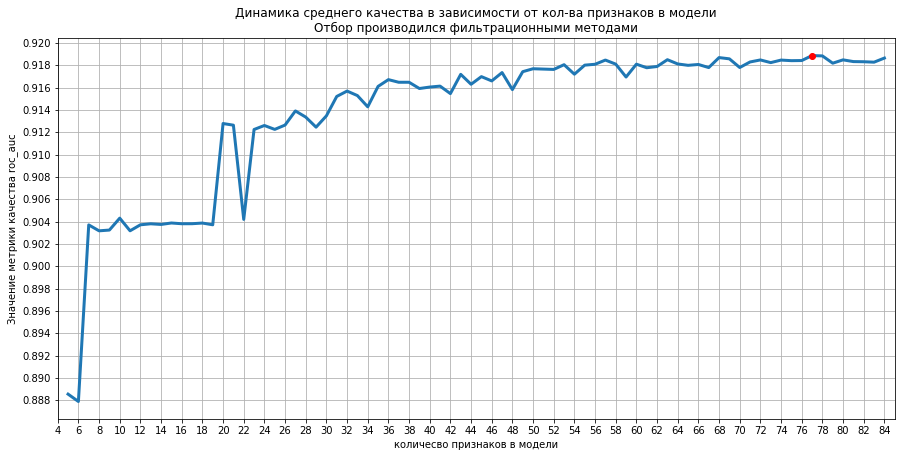

In [306]:
# график среднего качества

# Построение графика
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
ax.grid()    # наложили для удобства сетку
ax.plot(k_a, score_roc_auc_a, lw=3)
plt.xlim([4, 85])
    
ax.plot(k_a[score_roc_auc_a.index(max(score_roc_auc_a))],  max(score_roc_auc_a), marker='o', color='r')

ax.set_ylabel('Значение метрики качества roc_auc')
ax.set_xlabel('количесво признаков в модели')
ax.set_title('Динамика среднего качества в зависимости от кол-ва признаков в модели\nОтбор производился фильтрационными методами')
plt.show()

**Замечание:** Хотя наибольшее качество досттгается при k=77, однако, начиная с k=53 его увличение было незначительным. Поэтому будет считать, что согласно фильтрационным методам отбора в датасете надо оставить 53 признака. При повторном запуске самое высокое значение может немного изменится, но всегда будет довольно большимю

$\color{purple}{\text{пункт b) жадный отбор признаков}}$

In [ ]:
# ПРЕДУПРЕЖДЕНИЕ.
# НИ В КОЕМ СЛУЧАЕ НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ, ВЫПОЛНЯЕТСЯ ЧУТЬ МЕНЬШЕ 9-ТИ ЧАСОВ!!!
# СЕТКА ПАРАМЕТРОВ БЫЛА ВЗЯТА ДОВОЛЬНО МЕЛКАЯ (МНОГО ЗНАЧЕНИЙ ПЕРЕБИРАЕТСЯ) + ВЛОЖЕННЫЙ ЦИКЛ ТОЖЕ ПЕРЕБИРАЕТ
# ДОВОЛЬНО МНОГО ЗНАЧЕНИЙ (решила поэкспериментировать)

# чтобы можно было возпроизвести результаты, не запуская эту ячейку, я сохранила значения метрики качества и др в csv файл
#(его приладываю вместе с домашней работой). 

In [118]:
n_features = np.arange(5, 85, 1)
n_step = np.arange(1, 40, 2)
k_b = []
score_roc_auc_b = []
step = []

for i in tqdm(n_features):
    for j in tqdm(n_step):
        mean_roc_auc = 0
        rfe01 = RFE(LogisticRegression(), n_features_to_select=i, step = j)
        rfe = rfe01.fit_transform(Xnew2_f_copy, y)

        GB_cross_val = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                          max_features='auto', random_state=42),
                                       X=rfe, y=y, cv=5, scoring='roc_auc')
        mean_roc_auc = GB_cross_val.mean()

        k_b .append(i)
        step.append(j)
        score_roc_auc_b.append(mean_roc_auc)


 90%|█████████████████████████████████████▊    | 18/20 [02:21<00:12,  6.28s/it]


 80%|█████████████████████████████████▌        | 16/20 [02:39<00:35,  8.80s/it]


 70%|█████████████████████████████▍            | 14/20 [03:31<01:22, 13.70s/it]


 60%|█████████████████████████▏                | 12/20 [02:57<01:51, 13.98s/it]


 50%|█████████████████████                     | 10/20 [03:11<03:06, 18.65s/it]


 40%|█████████████████▏                         | 8/20 [03:12<04:41, 23.49s/it]


 30%|████████████▉                              | 6/20 [03:06<07:09, 30.69s/it]


 20%|████████▌                                  | 4/20 [02:15<09:01, 33.87s/it]


100%|███████████████████████████████████████| 80/80 [8:44:05<00:00, 393.07s/it]


In [119]:
k_b

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,


In [120]:
max(score_roc_auc_b)

0.9195159057804705

In [121]:
step

[1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,


In [151]:
score_roc_auc_b2 = pd.DataFrame(score_roc_auc_b, columns = ['score_roc_auc'])
k_b2 = pd.DataFrame(k_b)
step2 = pd.DataFrame(step)

score_roc_auc_b2_copy = copy.deepcopy(score_roc_auc_b2)
score_roc_auc_b2_copy['k'] = k_b
score_roc_auc_b2_copy['step'] = step

In [125]:
'''
score_roc_auc_b2.to_csv('C:\\Temp\\1\\score_roc_auc_b.csv')
k_b2.to_csv('C:\\Temp\\1\\k_b2.csv')
step2.to_csv('C:\\Temp\\1\\step.csv')
score_roc_auc_b2_copy.to_csv('C:\\Temp\\1\\score_roc_auc_b2_copy.csv')
'''

In [131]:
k_b[score_roc_auc_b.index(max(score_roc_auc_b))]

44

In [132]:
step[score_roc_auc_b.index(max(score_roc_auc_b))]

11

In [154]:
score_roc_auc_b2_copy

,score_roc_auc,k,step
0,0.862518,5,1
1,0.776923,5,3
2,0.862310,5,5
3,0.862310,5,7
4,0.862310,5,9
...,...,...,...
1595,0.918659,84,31
1596,0.918659,84,33
1597,0.918659,84,35
1598,0.918659,84,37


In [164]:
mean_score = score_roc_auc_b2_copy.groupby('k').mean()
mean_score_roc_auc = pd.DataFrame(mean_score)
mean_score_roc_auc['k'] = mean_score_roc_auc.index

In [166]:
mean_score_roc_auc

,score_roc_auc,step,k
k,,,
5,0.821316,20,5
6,0.831018,20,6
7,0.845406,20,7
8,0.859759,20,8
9,0.869901,20,9
...,...,...,...
80,0.918416,20,80
81,0.918448,20,81
82,0.918633,20,82


In [181]:
a = mean_score_roc_auc['score_roc_auc'].max()
best_k_b = mean_score_roc_auc.loc[mean_score_roc_auc['score_roc_auc'] == mean_score_roc_auc['score_roc_auc'].max()]

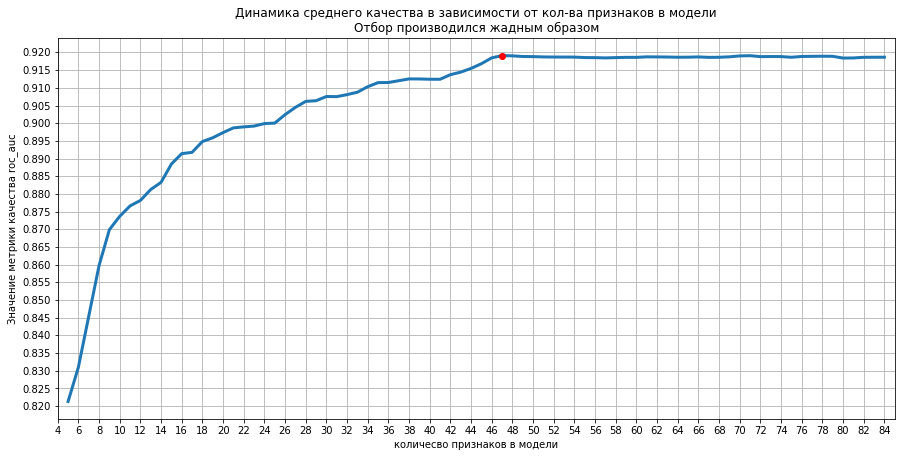

In [188]:
# Построение графика
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.grid()    # наложили для удобства сетку
ax.plot(mean_score_roc_auc['k'], mean_score_roc_auc['score_roc_auc'], lw=3)
plt.xlim([4, 85])
    
ax.plot(best_k_b['k'],  mean_score_roc_auc['score_roc_auc'].max(), marker='o', color='r')

ax.set_ylabel('Значение метрики качества roc_auc')
ax.set_xlabel('количесво признаков в модели')
ax.set_title('Динамика среднего качества в зависимости от кол-ва признаков в модели\nОтбор производился жадным образом')
plt.show()

In [183]:
best_k_b['k']

k
47    47
Name: k, dtype: int64

In [195]:
best_k_b2 = score_roc_auc_b2_copy[score_roc_auc_b2_copy['k'] == k_b[score_roc_auc_b.index(max(score_roc_auc_b))]]

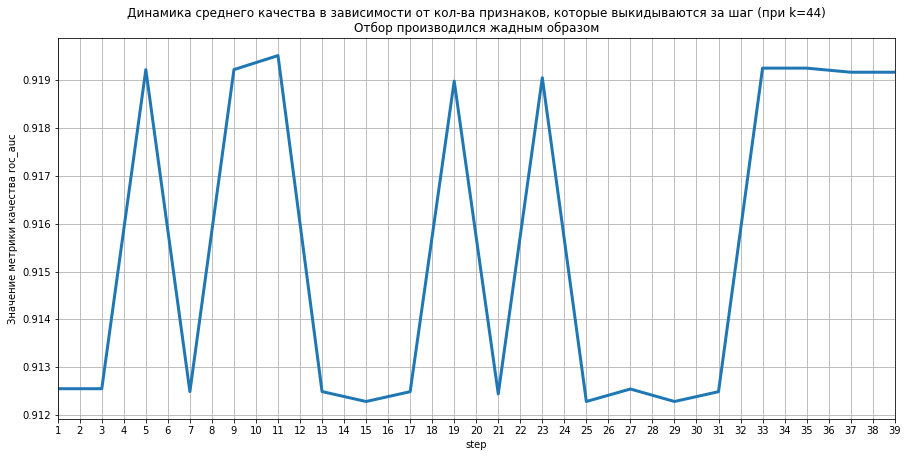

In [211]:
# Зафиксируем k на 44 и посмотрим как изменяется метрика качества  взависимости от step

# Построение графика
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax.grid()    # наложили для удобства сетку
ax.plot(best_k_b2['step'], best_k_b2['score_roc_auc'], lw=3)
plt.xlim([1, 39])
    
#ax.plot(best_k_b2['k'],  best_k_b2['score_roc_auc'].max(), marker='o', color='r')

ax.set_ylabel('Значение метрики качества roc_auc')
ax.set_xlabel('step')
ax.set_title('Динамика среднего качества в зависимости от кол-ва признаков, которые выкидываются за шаг (при k=44)\nОтбор производился жадным образом')
plt.show()

In [202]:
best_k_b2

,score_roc_auc,k,step
780,0.912552,44,1
781,0.912552,44,3
782,0.919223,44,5
783,0.912491,44,7
784,0.919223,44,9
785,0.919516,44,11
786,0.912492,44,13
787,0.912284,44,15
788,0.912490,44,17
789,0.918983,44,19


$\color{purple}{\text{пункт с) встроенные в модель методы}}$

In [122]:
# ТОЖЕ НЕ СТОИТ ЗАПУСКАТЬ ЭТУ ЯЧЕЙКУ (ВЫПОЛНЯЕТСЯ 22 МИН)

# В качестве встроенных в модель методов была выбрана L1-регуляризация в логистической регрессии.
thresholds = np.arange(1e-5, 1, 0.01)
threshold = []
score_roc_auc_c = []

for i in tqdm(thresholds):
    mean_roc_auc = 0
    sel_fr_m01 = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), threshold=i)
    sel_fr_m = sel_fr_m01.fit_transform(Xnew2_f_copy, y)
    
    grid_model = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                            max_features='auto', random_state=42), 
                                 sel_fr_m, y, cv=5, scoring='roc_auc')
    mean_roc_auc = grid_model.mean()
    
    threshold.append(i)
    score_roc_auc_c.append(mean_roc_auc)


100%|████████████████████████████████████████| 100/100 [22:08<00:00, 13.29s/it]


In [214]:
max(score_roc_auc_c)

0.9196873293701971

In [235]:
best_threshold = threshold[score_roc_auc_c.index(max(score_roc_auc_c))]
best_threshold

0.34001000000000003

In [216]:
score_roc_auc_c2 = pd.DataFrame(score_roc_auc_c, columns = ['score_roc_auc'])
threshold2 = pd.DataFrame(threshold)

score_roc_auc_c2_copy = copy.deepcopy(score_roc_auc_c2)
score_roc_auc_c2_copy['thresholds'] = threshold2

In [217]:
score_roc_auc_c2_copy

,score_roc_auc,thresholds
0,0.919258,0.00001
1,0.919198,0.01001
2,0.919180,0.02001
3,0.919211,0.03001
4,0.919262,0.04001
...,...,...
95,0.864551,0.95001
96,0.863510,0.96001
97,0.863510,0.97001
98,0.863510,0.98001


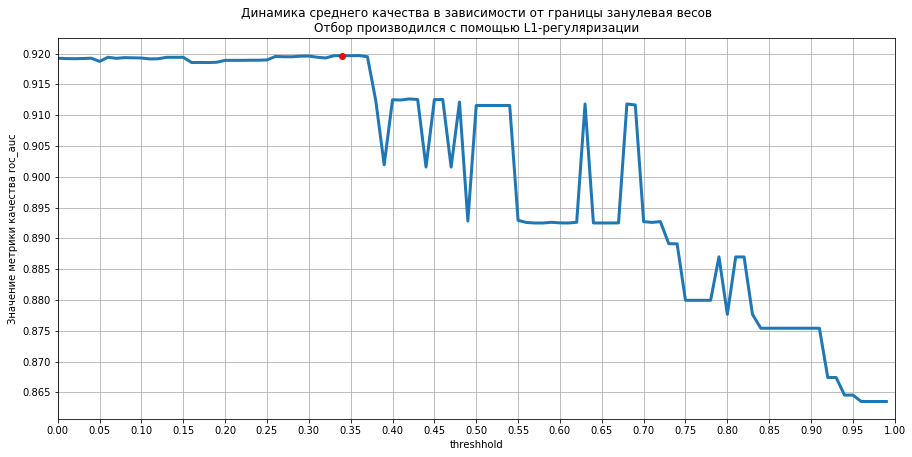

In [228]:
# Построение графика
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.grid()    # наложили для удобства сетку
ax.plot(score_roc_auc_c2_copy['thresholds'], score_roc_auc_c2_copy['score_roc_auc'], lw=3)
plt.xlim([0, 1])
    
ax.plot(threshold[score_roc_auc_c.index(max(score_roc_auc_c))],  score_roc_auc_c2_copy['score_roc_auc'].max(), marker='o', color='r')

ax.set_ylabel('Значение метрики качества roc_auc')
ax.set_xlabel('threshhold')
ax.set_title('Динамика среднего качества в зависимости от границы занулевая весов\nОтбор производился с помощью L1-регуляризации')
plt.show()

In [232]:
print('best mean score roc_auc, полученный с помощью фильтрационных методов:', max(score_roc_auc_a))
print('best mean score roc_auc, полученный с помощью жадного отбора:', max(score_roc_auc_b))
print('best mean score roc_auc, полученный с помощью встроенных в модель методов:', max(score_roc_auc_c))

best mean score roc_auc, полученный с помощью встроенных в модель методов: 0.9195159057804705
best mean score roc_auc, полученный с помощью встроенных в модель методов: 0.9196873293701971


$\Large \;\;\color{purple}{\text{Построение моделей}}$

Создадим датасет из признаков с помощью метода, который показал себя наилечгим образом. Как можно
заметить выше, все методы отбора признаков дают примерно одинаковый результат. Различие идет только в 4 знаке после запятой. Давайте возьмем встроенные в модель методы, которые были посчитаны с помощью L1-регуляризации в логистической регрессии.

In [236]:
sel_fr_m01_v2 = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), threshold=best_threshold)
sel_fr_m_v2 = sel_fr_m01_v2.fit_transform(Xnew2_f_copy, y)

In [242]:
Xnew_sel = pd.DataFrame(sel_fr_m_v2)
Xnew_sel.shape

(15347, 33)

In [240]:
Xnew_sel

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.342919,1.588223,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.342919,-0.450788,-0.065600,1.588223,-0.444535,0.616742,-0.075947,-0.037747,-0.207216,1.647326
1,0.114760,-0.074178,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114760,-0.059086,-0.150439,-0.074178,-0.048019,0.013840,-0.076485,-0.140045,-0.207216,-0.200415
2,-0.190359,-0.074178,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.190359,1.116020,-0.150439,-0.074178,-0.319507,-0.205397,-0.076485,-0.140045,-0.207216,-0.200415
3,-1.258276,-0.905379,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.258276,-0.059086,-0.150439,-0.905379,-1.044667,-1.274177,-0.076485,-0.140045,-0.207216,-0.847125
4,0.648719,-0.074178,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.648719,1.116020,1.995391,-0.074178,0.495851,0.397505,0.267904,1.584899,-0.207216,-0.200415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,-0.074178,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.029436,1.116020,-0.150439,-0.074178,-0.918746,-0.808299,-0.076485,-0.140045,-0.207216,-0.200415
15343,-0.495478,0.341422,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.495478,1.116020,1.995391,0.341422,-0.562418,-0.205397,0.267904,1.800517,-0.207216,0.192230
15344,-0.876877,-0.074178,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.876877,1.116020,-0.150439,-0.074178,-0.825869,-0.698680,-0.076485,-0.140045,-0.207216,-0.200415
15345,1.564076,-0.074178,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.564076,-0.450788,-0.150439,-0.074178,1.631816,1.055217,-0.076485,-0.140045,-0.207216,-0.200415


In [ ]:
# Осталось 33 признака

$\color{purple}{\text{KNN}}$

In [243]:
kNN_cross_val_2 = cross_val_score(KNeighborsClassifier(metric = 'manhattan', n_neighbors = 65),
                                X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model kNN:', kNN_cross_val_2.mean())

best mean score roc_auc by model kNN: 0.8972323936305544


$\color{purple}{\text{Decision Tree}}$

In [244]:
DT_cross_val_2 = cross_val_score(DecisionTreeClassifier(criterion ='entropy', max_depth = 8, random_state=42),
                                X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Decision Tree:', DT_cross_val_2.mean())

best mean score roc_auc by model Decision Tree: 0.8924401894960488


$\color{purple}{\text{Random Forest}}$

In [245]:
RF_cross_val_2 = cross_val_score(RandomForestClassifier(n_estimators = 140, criterion='entropy', max_features='auto',
                                                     random_state=42),
                                X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Random Forest:', RF_cross_val_2.mean())

best mean score roc_auc by model Random Forest: 0.8890537477890043


$\color{purple}{\text{Gradient Boosting}}$

In [246]:
GB_cross_val_2 = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                          max_features='auto', random_state=42),
                                X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model Gradient Boosting:', GB_cross_val_2.mean())

best mean score roc_auc by model Gradient Boosting: 0.9196873293701971


$\color{purple}{\text{SGD Linear Classifier}}$

In [247]:
SGD_cross_val_2 = cross_val_score(SGDClassifier(loss='log', penalty='elasticnet'),
                                X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

print('best mean score roc_auc by model SGD Linear Classifier:', SGD_cross_val_2.mean())

best mean score roc_auc by model SGD Linear Classifier: 0.9056450022724748


Позволил ли этот подход улучшить качество моделей? 

In [277]:
data_metrics_sel = [kNN_cross_val_2.mean(), DT_cross_val_2.mean(), RF_cross_val_2.mean(),
                    GB_cross_val_2.mean(), SGD_cross_val_2.mean()]

metrics.loc[len(metrics)] = data_metrics_sel
metrics.index = ['Неотмасштабированные признаки', 'Отмасштабированные признаки', 'С добавление категориальных признаков',
                'Отобранные признаки']


In [279]:
metrics

,KNN,Decision Tree,Random Forest,Gradient Boosting,SGD Linear Classifier
Неотмасштабированные признаки,0.640717,0.841435,0.818286,0.862117,0.609055
Отмасштабированные признаки,0.834238,0.841404,0.818286,0.862117,0.821853
С добавление категориальных признаков,0.891143,0.890875,0.901606,0.919088,0.901445
Отобранные признаки,0.897232,0.892440,0.889054,0.919687,0.905645


**Ответ:** По сравнению с предыдущими моделями, построенными на датафрейме с отмасштабированными числовыми признаками и добавлением категориальных признаков, улучшение произошли максимально незначительные. А в случайном лесе качество даже упало. Но все же в остальных моделях начество подросло немного.

Таким образом, данный подход (для данного дадасета) не особо был полезен, учтывая, сколько времени ушло на выполнение кода.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [281]:
clf1 = SGDClassifier(loss= 'log', penalty='elasticnet')
clf2 = GradientBoostingClassifier(n_estimators=100,
                                  criterion='friedman_mse', 
                                  max_features='auto',
                                  random_state=42)

comb_model = VotingClassifier(estimators=[ ('clf1', clf1), ('clf2', clf2)], 
                              voting='soft')

In [282]:
# создадим массив из весов моделей, перебирая альфы
weights = []
for i in np.arange(0, 1.1, 0.1):
    weights.append([i, 1 - i])


# переберем пары весов для модели по кросс-валидации
grid_comb_model01 = GridSearchCV(comb_model,
                      param_grid = {'weights': weights},
                      cv = 5,
                      scoring='roc_auc',
                      verbose=3)

# Обучили модель на ВСЕХ данных
grid_comb_model = grid_comb_model01.fit(Xnew_sel, y)
print('best score roc_auc by model kNN:', grid_comb_model.best_score_)
    # grid.best_score_ - посмотрим на лучшее качество
print('best params by model kNN:', grid_comb_model.best_params_)
    # grid.best_params_ - посмотрим на наилучшее значение параметра

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] weights=[0.0, 1.0] ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. weights=[0.0, 1.0], score=0.919, total=   2.7s
[CV] weights=[0.0, 1.0] ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .................. weights=[0.0, 1.0], score=0.924, total=   2.3s
[CV] weights=[0.0, 1.0] ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] .................. weights=[0.0, 1.0], score=0.921, total=   2.4s
[CV] weights=[0.0, 1.0] ..............................................
[CV] .................. weights=[0.0, 1.0], score=0.917, total=   2.4s
[CV] weights=[0.0, 1.0] ..............................................
[CV] .................. weights=[0.0, 1.0], score=0.917, total=   2.4s
[CV] weights=[0.1, 0.9] ..............................................
[CV] .................. weights=[0.1, 0.9], score=0.919, total=   2.4s
[CV] weights=[0.1, 0.9] ..............................................
[CV] .................. weights=[0.1, 0.9], score=0.924, total=   2.4s
[CV] weights=[0.1, 0.9] ..............................................
[CV] .................. weights=[0.1, 0.9], score=0.921, total=   2.4s
[CV] weights=[0.1, 0.9] ..............................................
[CV] .................. weights=[0.1, 0.9], score=0.917, total=   2.8s
[CV] weights=[0.1, 0.9] ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  2.3min finished


best score roc_auc by model kNN: 0.9196873293701971
best params by model kNN: {'weights': [0.0, 1.0]}


Text(0.5, 1.0, 'Динамика среднего качества в зависимости от параметра alpha')

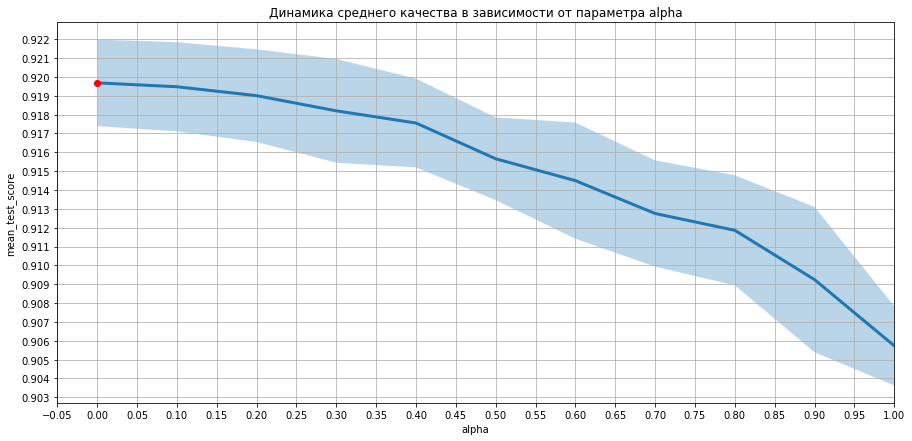

In [288]:
# график среднего качества

# Положим в датафрейм некоторые характеристики 
df_comb_model_res = pd.DataFrame(grid_comb_model.cv_results_)
y_comb_model = df_comb_model_res['mean_test_score']
x_comb_model = np.arange(0, 1.1, 0.1)
weights_best = weights[np.argmin(max(y_comb_model))]
alpha_best = weights_best[0]

# Построение графика
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax.grid()    # наложили для удобства сетку
ax.plot(x_comb_model, y_comb_model, lw=3)
plt.xlim([-0.05, 1])
    
# 95% доверительный интервал
y_coordinate_up = df_comb_model_res['mean_test_score'] + 1.96 * (df_comb_model_res['std_test_score']/5**(1/2))
y_coordinate_low = df_comb_model_res['mean_test_score'] - 1.96 * (df_comb_model_res['std_test_score']/5**(1/2))
ax.fill_between(x_comb_model, y_coordinate_low, y_coordinate_up, alpha = 0.3)

ax.plot(alpha_best, y_comb_model.max(), marker='o', color='r')

ax.set_ylabel('mean_test_score')
ax.set_xlabel('alpha')
ax.set_title('Динамика среднего качества в зависимости от параметра alpha')

**Ответ:** Исходя из весов, которые были получены по кросс-валидации (weights = (0, 1)) получается, что градиентного бустинга достаточно для достижения максимально возможного качества. Т.е. модель SGD Linear Classifier полностью занулилась и все расчеты проводились только по градиентному бустинг.

Таким образом, прироста качества от смешивания моделей нет!

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

$\Large \;\;\color{purple}{\text{Модели}}$

In [289]:
kNN_cross_val_finish = cross_val_score(KNeighborsClassifier(metric = 'manhattan', n_neighbors = 65),
                                       X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

DT_cross_val_finish = cross_val_score(DecisionTreeClassifier(criterion ='entropy', max_depth = 8, random_state=42),
                                      X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

RF_cross_val_finish = cross_val_score(RandomForestClassifier(n_estimators = 140, criterion='entropy', max_features='auto',
                                                     random_state=42),
                                      X=Xnew2, y=y, cv=5, scoring='roc_auc')

GB_cross_val_finish = cross_val_score(GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', 
                                                          max_features='auto', random_state=42),
                                      X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

SGD_cross_val_finish = cross_val_score(SGDClassifier(loss='log', penalty='elasticnet'),
                                       X=Xnew_sel, y=y, cv=5, scoring='roc_auc')


In [292]:
comb_model_best = VotingClassifier(estimators=[ ('clf1', clf1), ('clf2', clf2)], 
                                   voting='soft', weights = [0.0, 1.0])
comb_model_cross_val = cross_val_score(comb_model_best, 
                                       X=Xnew_sel, y=y, cv=5, scoring='roc_auc')

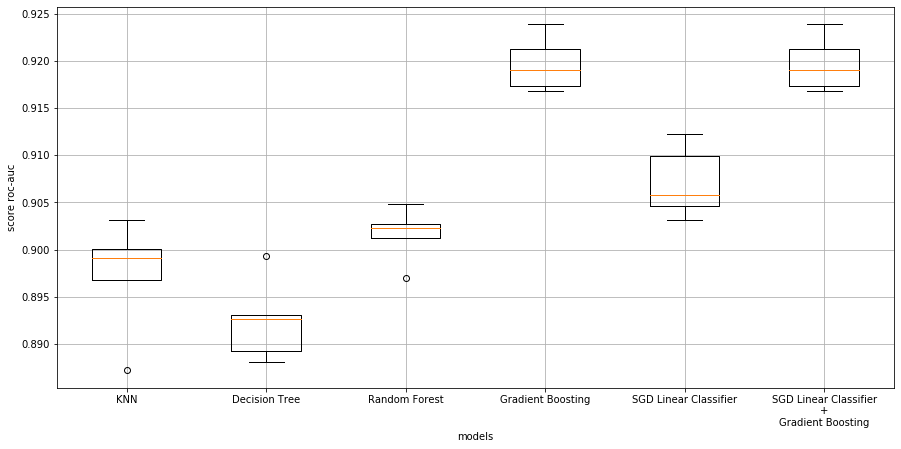

In [294]:
fig, ax = plt.subplots(figsize=(15,7))
plt.boxplot([kNN_cross_val_finish, DT_cross_val_finish, RF_cross_val_finish, GB_cross_val_finish,
             SGD_cross_val_finish, comb_model_cross_val])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.set_xticklabels(['KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting',
                    'SGD Linear Classifier', 'SGD Linear Classifier\n+\nGradient Boosting'])
ax.set_xlabel('models')
ax.set_ylabel('score roc-auc')
ax.grid()

plt.show()

In [295]:
metrics

,KNN,Decision Tree,Random Forest,Gradient Boosting,SGD Linear Classifier
Неотмасштабированные признаки,0.640717,0.841435,0.818286,0.862117,0.609055
Отмасштабированные признаки,0.834238,0.841404,0.818286,0.862117,0.821853
С добавление категориальных признаков,0.891143,0.890875,0.901606,0.919088,0.901445
Отобранные признаки,0.897232,0.892440,0.889054,0.919687,0.905645


**Общие выводы:**

*Наилучшая модель*: из графика видно, что наилучший результат roc_auc по кросс-валидации дает градиентный бустинг (ну и смешенная модель, поскольку в ней с весом 1 учатсвует градиентный бустинг).

*Работа с признаками*<br/>
KNN считает расстояния между объектами, поэтому он может плохо работать, когда признаки имеют сильно разный диапазон значений. SGD тоже не очень хоршо справляется с такими признаками, поскольку он использует их линейную комбинацию. Решающие деревья в каждом узле проверяют некоторое отдельное условие, которое касается только одного конкретного признака, поэтому для него признаки с разным диапазоном значений не проблема (это распространяется и на случайный лес, и на градиентный буустинг, так как в их основе лежат решающие деревья).<br/>
Конечно, чем больше признаков, тем они скорее всего лучше объясняют поведение зависимой переменной, лучше прогнозы и, следовательно, метрики качества будут выше. Этот вывод подтверждается из построенных моделей. При добавлении категориальных признаков у всех моделей roc-auc стал значительно выше.  

*Сложность моделей и гипрепараметры*<br/>
Гиперапарметры каждой модели позволяют лучше подстроиться под конкретную задачу.<br/>
Влияние гиперпараметров на модель зависит от того, какой смысл несет в себе этот гиперпараметр. Например, кол-во деревьев в бустинге сильно скажется на качестве алгоритма, так как в помощью n_estimators в бустинге регулируется переобучение. Какие то параметры, типа критерия информативности (джини или энтропия), не очень влияют на качество модели. так как выдают примерно одно и то же.<br/>
Наиболее сложными алгоритмами являются градиентный бустинг и лес. Отдать предпочтение одному из них нельзя, так как каждый из них по разному проявяет себя на разных питах данных (где-то лес лучше, где то бустинг). В нашем случае наиболее эффективным оказался бустинг. И, как и говорилось на лекции, лучше алгоритмов чем имплементации бустинга для табличных данных не существует. Это и видно на нашем примере. Самым лучшим алгоритмом оказался градиентный бустинг.